##### Exploratory Data Analysis (EDA):

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import itertools
warnings.filterwarnings('ignore')

In [63]:
df_2022 = pd.read_csv('../../datasets/daily_aqi_by_county_2022-2.csv')
df_2023 = pd.read_csv('../../datasets/daily_aqi_by_county_2023-1.csv')
df_2024 = pd.read_csv('../../datasets/daily_aqi_by_county_2024.csv') # This dataset differs from the one offered in the assignment since it seems like some dates got clipped.

# column 'AQI' is my target, and using the other column 'Date' as the series column I'll use time series regression techniques.
# df_2024.head(5)


In [64]:
# First I'll need to extract Only Utah from State Name, and Weber County from County Name.
# Filter for rows where State Name is 'Utah' and county Name is 'Weber'
df_2022_filtered = df_2022[(df_2022['State Name'] == 'Utah') & (df_2022['county Name'] == 'Weber')]
df_2022_filtered = df_2022_filtered.reset_index(drop=True)

df_2023_filtered = df_2023[(df_2023['State Name'] == 'Utah') & (df_2023['county Name'] == 'Weber')]
df_2023_filtered = df_2023_filtered.reset_index(drop=True)

df_2024_filtered = df_2024[(df_2024['State Name'] == 'Utah') & (df_2024['county Name'] == 'Weber')]
df_2024_filtered = df_2024_filtered.reset_index(drop=True)

# Keep only Date and AQI, convert Date to datetime, and set it as index
for df in [df_2022_filtered, df_2023_filtered, df_2024_filtered]:
    df.drop(columns=[col for col in df.columns if col not in ['Date', 'AQI']], inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

# print('Row Count for Each Year:')
# print('2022:', len(df_2022_filtered))
# print('2023:', len(df_2023_filtered))
# print('2024:', len(df_2024_filtered))


The data was loaded in and filtered to remove all columns except for State Name, and county Name. Then additional steps were taken to only grab rows with Utah, and Weber in their state and county name. 2022 had 365 rows, 2023 had 365 rows, and 2024 had 366 rows. This meant that there was a valid data entry for every single day, and this was proven to be true since there were no missing or NA values in these datasets.

In [65]:
# Create visual-only copies with just Date, AQI, and Year
df_2022_vis = df_2022_filtered[['AQI']].copy()
df_2022_vis['Year'] = 2022

df_2023_vis = df_2023_filtered[['AQI']].copy()
df_2023_vis['Year'] = 2023

df_2024_vis = df_2024_filtered[['AQI']].copy()
df_2024_vis['Year'] = 2024

# Combine for visualization
df_vis_all = pd.concat([df_2022_vis, df_2023_vis, df_2024_vis])

# Convert Date and set index
# df_vis_all['Date'] = pd.to_datetime(df_vis_all['Date'])
# df_vis_all.set_index('Date', inplace=True)

# print('Check for missing/na values:')
# print(df_vis_all.isna().sum())

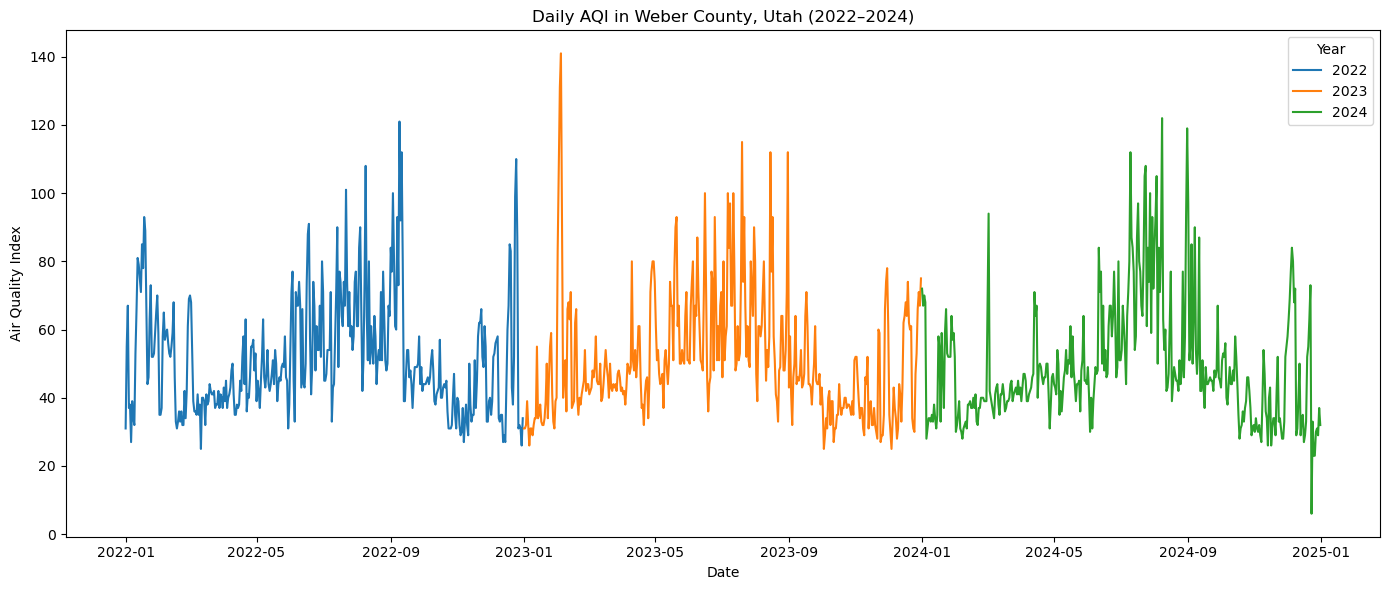

In [66]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_vis_all, x=df_vis_all.index, y='AQI', hue='Year', palette='tab10')
plt.title('Daily AQI in Weber County, Utah (2022–2024)')
plt.xlabel('Date')
plt.ylabel('Air Quality Index')
plt.legend(title='Year')
plt.tight_layout()
plt.show()

The daily AQI shows that there is quite a bit of fluctuations day to day, and that each year follows a similar pattern. This means there is seasonality is present in this data.

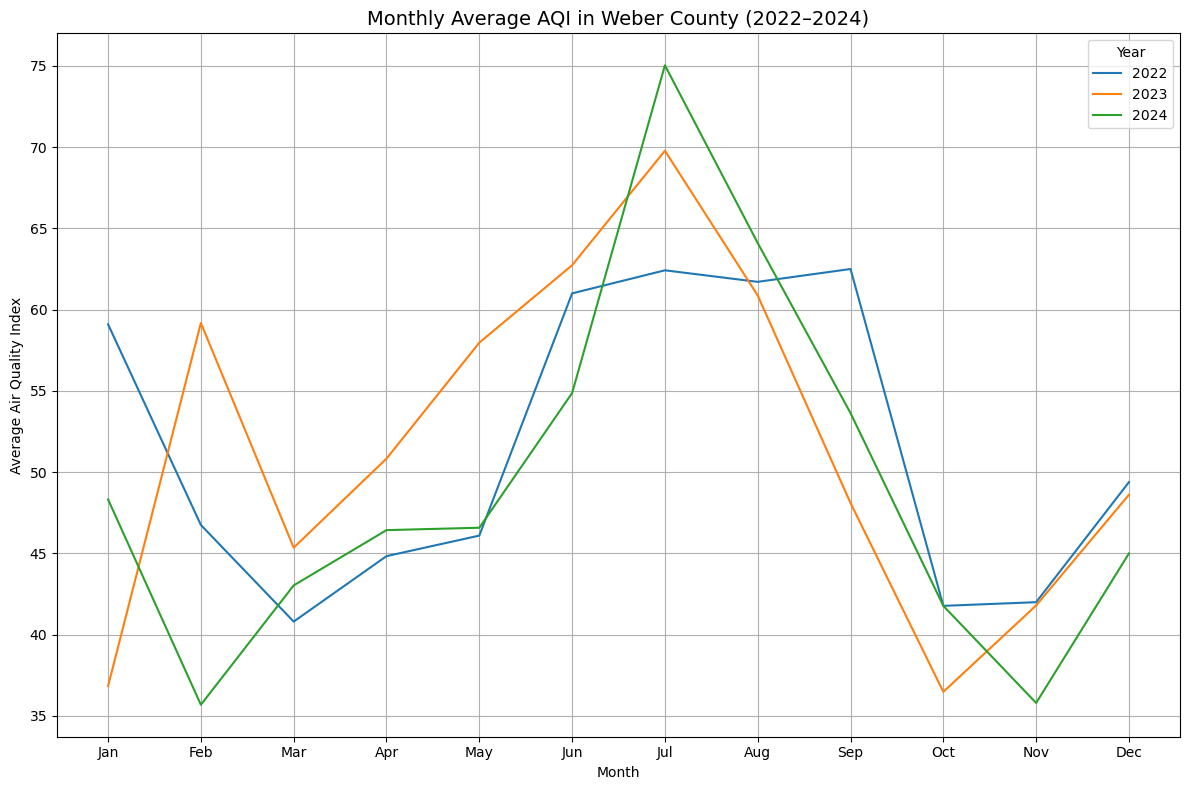

In [67]:
# Aggregate monthly mean AQI
df_2022_monthly = df_2022_vis.resample('ME').mean()
df_2023_monthly = df_2023_vis.resample('ME').mean()
df_2024_monthly = df_2024_vis.resample('ME').mean()

# Add 'Month' and 'Year' columns for plotting
df_2022_monthly['Month'] = df_2022_monthly.index.month
df_2022_monthly['Year'] = 2022

df_2023_monthly['Month'] = df_2023_monthly.index.month
df_2023_monthly['Year'] = 2023

df_2024_monthly['Month'] = df_2024_monthly.index.month
df_2024_monthly['Year'] = 2024

# Combine all years
df_all_monthly = pd.concat([df_2022_monthly, df_2023_monthly, df_2024_monthly])

# Plot monthly AQI trends
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_all_monthly, x='Month', y='AQI', hue='Year', palette=['#1f77b4', '#ff7f0e', '#2ca02c'])

plt.title('Monthly Average AQI in Weber County (2022–2024)', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Average Air Quality Index')
plt.xticks(ticks=np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()

Using the monthly average of the AQI shows a smoother line and a bigger picture view of how the data has changed over the years. However, it can smooth the line too much and it may not be able to capture short-term AQI fluctuations and changes. Smoothing out the graph also shows the obvious point where we have a seasonal trend. The month of July consistently jumps up in AQI.

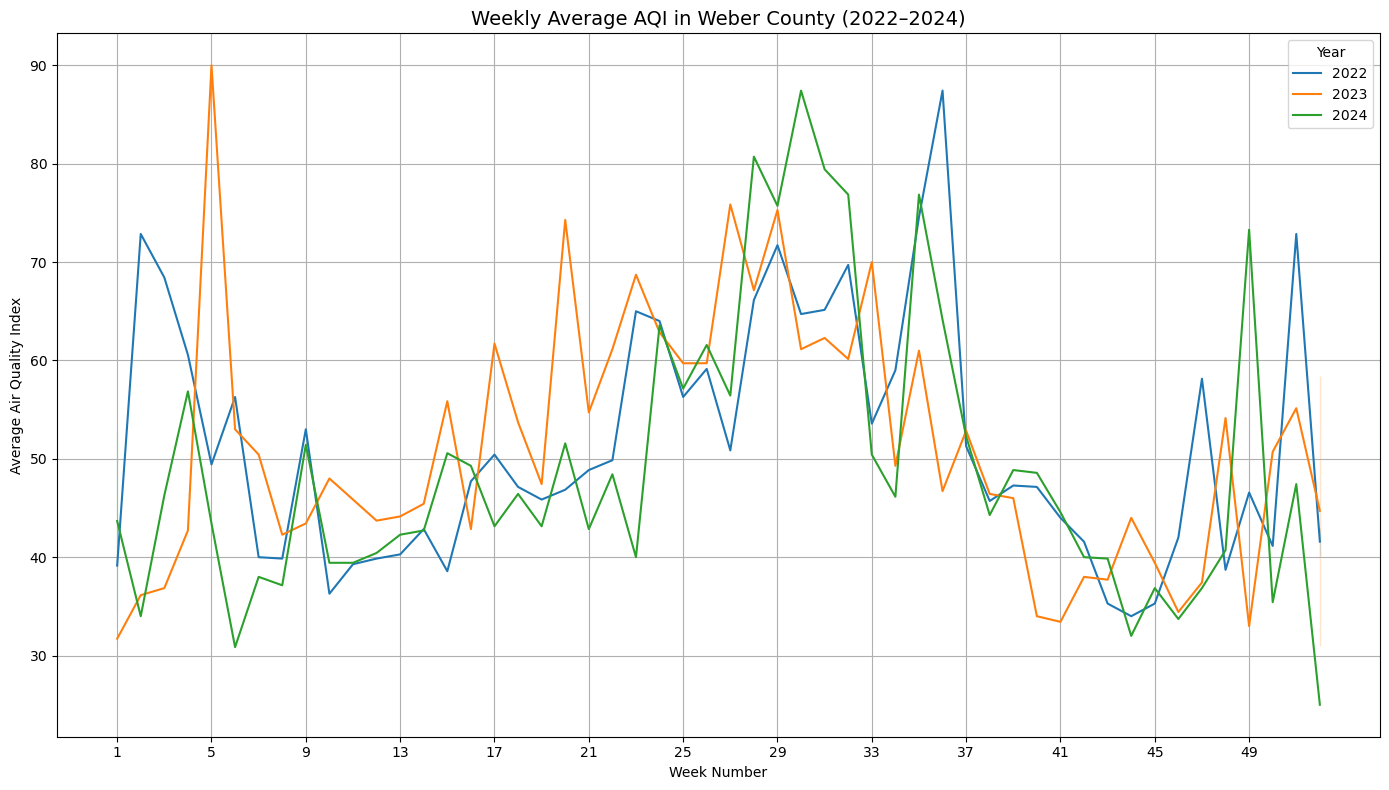

In [68]:
# Aggregate weekly mean AQI
df_2022_weekly = df_2022_vis.resample('W').mean()
df_2023_weekly = df_2023_vis.resample('W').mean()
df_2024_weekly = df_2024_vis.resample('W').mean()

# Add 'Week' and 'Year' columns for plotting
df_2022_weekly['Week'] = df_2022_weekly.index.isocalendar().week
df_2022_weekly['Year'] = 2022

df_2023_weekly['Week'] = df_2023_weekly.index.isocalendar().week
df_2023_weekly['Year'] = 2023

df_2024_weekly['Week'] = df_2024_weekly.index.isocalendar().week
df_2024_weekly['Year'] = 2024

# Combine all years
df_all_weekly = pd.concat([df_2022_weekly, df_2023_weekly, df_2024_weekly])
df_all_weekly.sort_values(['Year', 'Week'], inplace=True)

# Plot weekly AQI trends
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_all_weekly, x='Week', y='AQI', hue='Year', palette=['#1f77b4', '#ff7f0e', '#2ca02c'])

plt.title('Weekly Average AQI in Weber County (2022–2024)', fontsize=14)
plt.xlabel('Week Number')
plt.ylabel('Average Air Quality Index')
plt.xticks(ticks=np.arange(1, 53, 4))  # Show every 4th week for readability
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()


Looking at the weekly changes in AQI shows that there seems to be some seasonality and trends in the data, but we can see short-term fluctuations as well. This may be an applicable middle ground since the lines aren't as smooth as they are in the monthly AQI plot.

##### Reason for Aggregation:

Upon initial data exploration, while there is enough data for daily time series modeling, the distribution was skewed right, and the daily trends were quite jagged. So, when graphing both monthly and weekly averages the monthly data looked a little too smooth, and weekly data looked to be the most promising since there are still obvious seasonal patterns and the data didn't look so smooth over it wouldn't capture other trends.

So, to capture as many AQI patterns as possible the weekly and monthly data will be used to compare results.

This means that from the daily AQI data we will aggregate the weekly and monthly means for analyzing, and AQI forecasting.

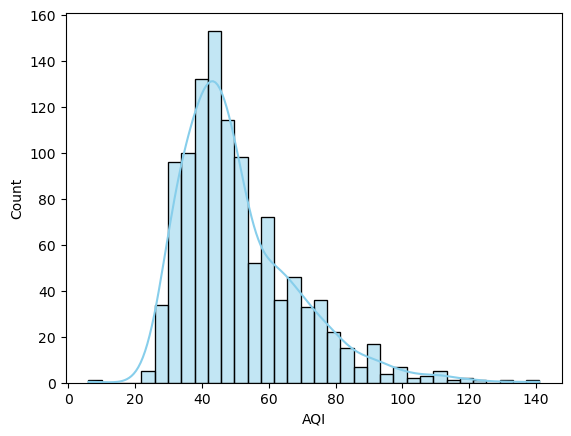

In [69]:
sns.histplot(df_vis_all['AQI'], kde=True, color='skyblue');


The daily AQI variance is a little skewed to the right, and so aggregation will be a good idea for making the variance more normal.

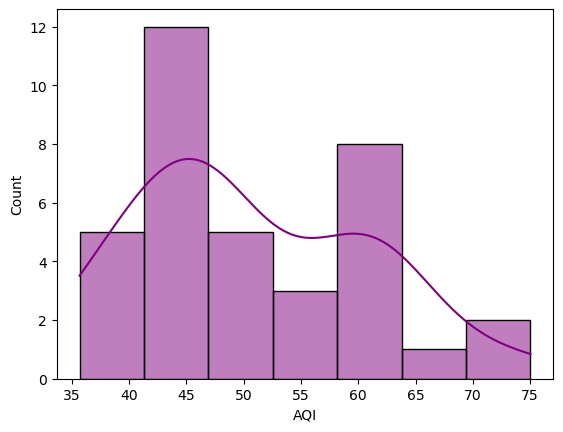

In [70]:
sns.histplot(df_all_monthly['AQI'], kde=True, color='purple');

The monthly AQI data shows a similar right-skewed pattern, but the tail is a little smaller now.

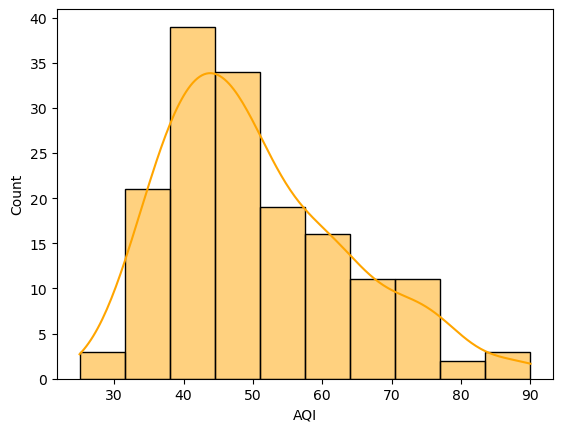

In [71]:
sns.histplot(df_all_weekly['AQI'], kde=True, color='orange');

The variance is not as prevalent, but still there, so we will move to log transformations to ensure the data is stationary.

##### Transformations:

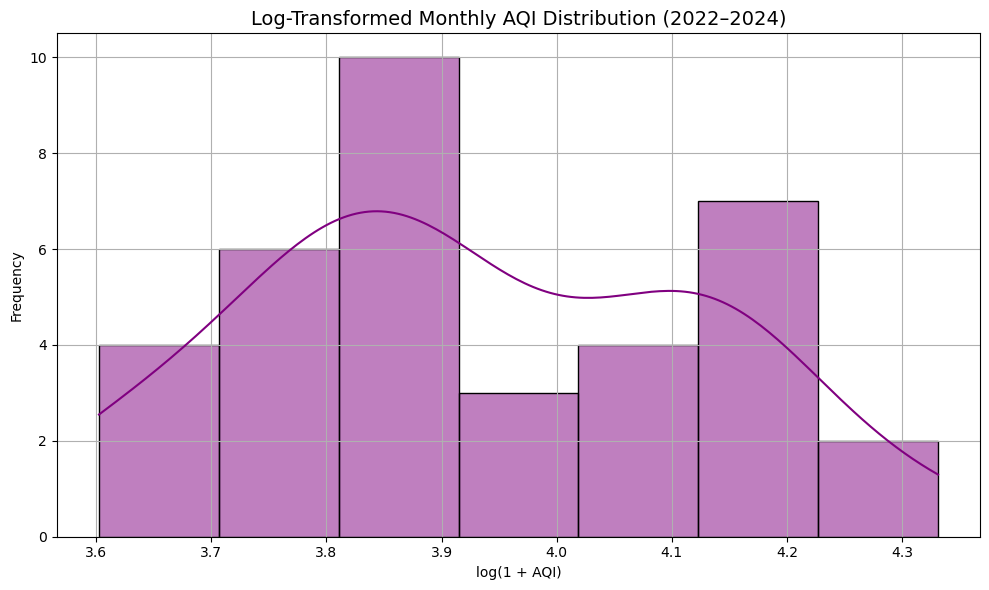

In [72]:
# Step 1: Apply log transformation
df_all_monthly['AQI_log'] = np.log1p(df_all_monthly['AQI'])

# Step 2: Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_all_monthly['AQI_log'], kde=True, color='purple')
plt.title('Log-Transformed Monthly AQI Distribution (2022–2024)', fontsize=14)
plt.xlabel('log(1 + AQI)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


The distribution looks quite normal now after log transformation.

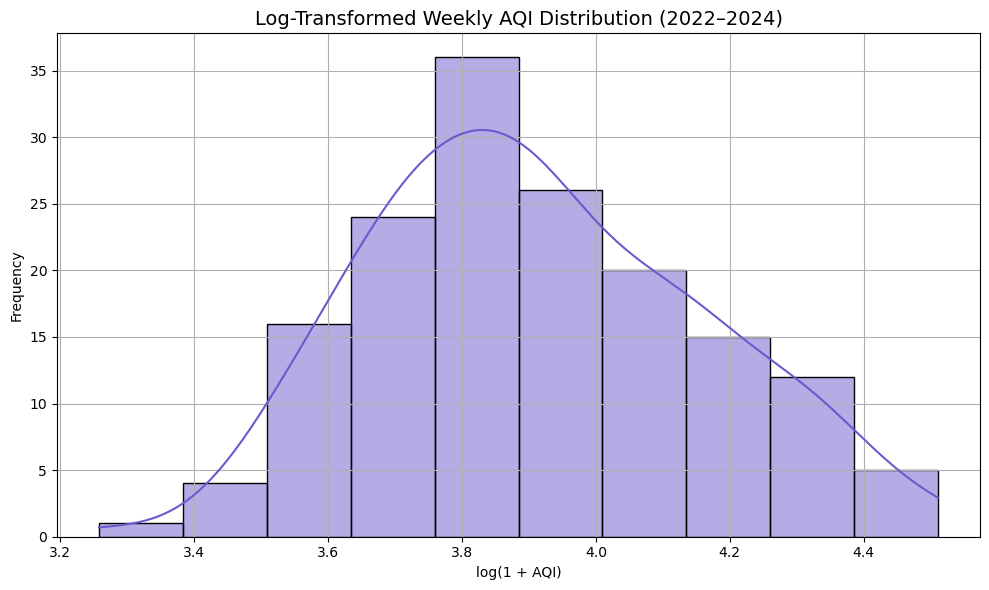

In [73]:
# Step 1: Apply log transformation
df_all_weekly['AQI_log'] = np.log1p(df_all_weekly['AQI'])

# Step 2: Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_all_weekly['AQI_log'], kde=True, color='slateblue')
plt.title('Log-Transformed Weekly AQI Distribution (2022–2024)', fontsize=14)
plt.xlabel('log(1 + AQI)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


The log transformed weekly data also shows a more normal variance when plotted.

##### Seasonal Patterns:

We first noticed the seasonality of the data in the Daily AQI graph, and it was made clear there was seasonality when graphing the aggregated monthly avg AQI dataset. To get rid of this seasonality seasonal differencing will be needed to ensure this data set is stationary and ready for modeling.

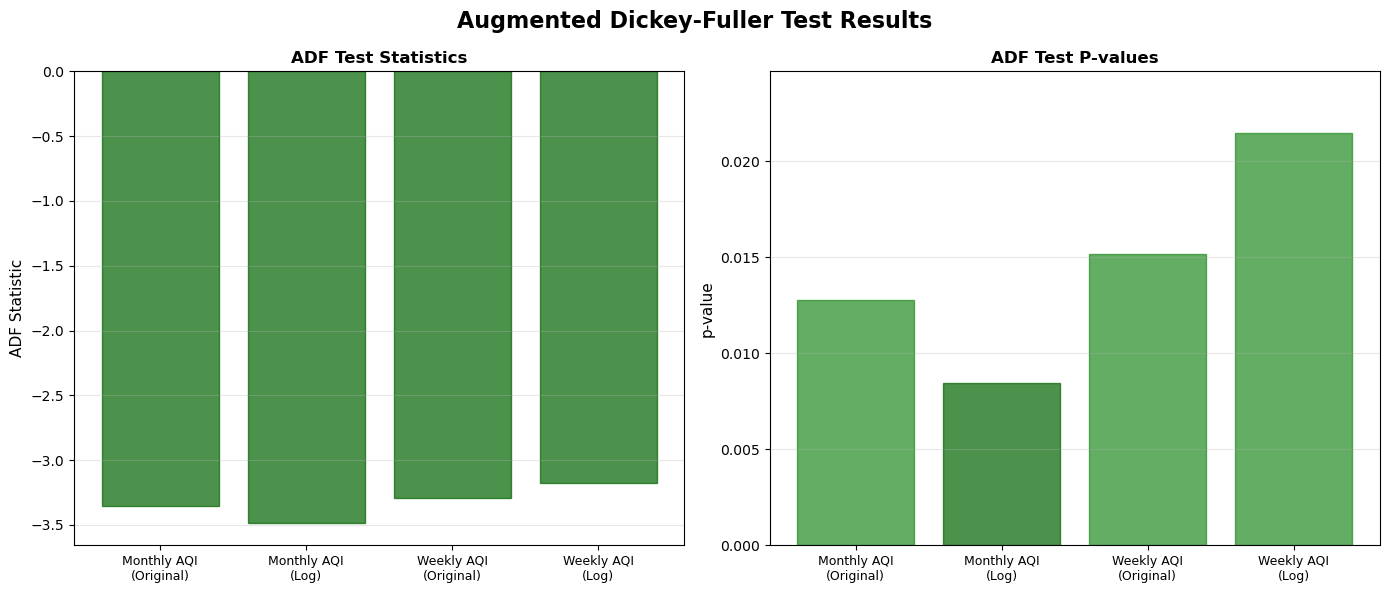

In [74]:
# --- Perform ADF tests and store results ---
adf_results = []

# Monthly AQI without log
adf_monthly = adfuller(df_all_monthly['AQI'].dropna())
adf_results.append({
    'Dataset': 'Monthly AQI',
    'Transformation': 'Original',
    'ADF Statistic': adf_monthly[0],
    'p-value': adf_monthly[1],
    'Critical Value (1%)': adf_monthly[4]['1%'],
    'Critical Value (5%)': adf_monthly[4]['5%']
})

# Monthly AQI with log
adf_monthly_log = adfuller(df_all_monthly['AQI_log'].dropna())
adf_results.append({
    'Dataset': 'Monthly AQI',
    'Transformation': 'Log',
    'ADF Statistic': adf_monthly_log[0],
    'p-value': adf_monthly_log[1],
    'Critical Value (1%)': adf_monthly_log[4]['1%'],
    'Critical Value (5%)': adf_monthly_log[4]['5%']
})

# Weekly AQI without log
adf_weekly = adfuller(df_all_weekly['AQI'].dropna())
adf_results.append({
    'Dataset': 'Weekly AQI',
    'Transformation': 'Original',
    'ADF Statistic': adf_weekly[0],
    'p-value': adf_weekly[1],
    'Critical Value (1%)': adf_weekly[4]['1%'],
    'Critical Value (5%)': adf_weekly[4]['5%']
})

# Weekly AQI with log
adf_weekly_log = adfuller(df_all_weekly['AQI_log'].dropna())
adf_results.append({
    'Dataset': 'Weekly AQI',
    'Transformation': 'Log',
    'ADF Statistic': adf_weekly_log[0],
    'p-value': adf_weekly_log[1],
    'Critical Value (1%)': adf_weekly_log[4]['1%'],
    'Critical Value (5%)': adf_weekly_log[4]['5%']
})

# Create DataFrame
adf_df = pd.DataFrame(adf_results)

# --- Create visualization ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Augmented Dickey-Fuller Test Results', fontsize=16, fontweight='bold')

# Plot 1: ADF Statistics
ax1 = axes[0]
x_pos = np.arange(len(adf_df))
bars = ax1.bar(x_pos, adf_df['ADF Statistic'], color='steelblue', alpha=0.7, edgecolor='black')

# Color bars based on stationarity (if ADF stat < critical value at 5%, it's stationary)
for i, (bar, row) in enumerate(zip(bars, adf_df.iterrows())):
    if row[1]['ADF Statistic'] < row[1]['Critical Value (5%)']:
        bar.set_color('darkgreen')
    else:
        bar.set_color('tomato')

ax1.set_xticks(x_pos)
ax1.set_xticklabels([f"{row['Dataset']}\n({row['Transformation']})" 
                      for _, row in adf_df.iterrows()], fontsize=9)
ax1.set_ylabel('ADF Statistic', fontsize=11)
ax1.set_title('ADF Test Statistics', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: P-values
ax2 = axes[1]
bars2 = ax2.bar(x_pos, adf_df['p-value'], color='steelblue', alpha=0.7, edgecolor='black')

# Color bars based on significance (p < 0.05 = stationary)
for bar, pval in zip(bars2, adf_df['p-value']):
    if pval < 0.01:
        bar.set_color('darkgreen')
    elif pval < 0.05:
        bar.set_color('forestgreen')
    else:
        bar.set_color('tomato')

ax2.set_xticks(x_pos)
ax2.set_xticklabels([f"{row['Dataset']}\n({row['Transformation']})" 
                      for _, row in adf_df.iterrows()], fontsize=9)
ax2.set_ylabel('p-value', fontsize=11)
ax2.set_title('ADF Test P-values', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, max(adf_df['p-value']) * 1.15])

plt.tight_layout()
plt.show()

We can interpret the adf statistic as the more negative, the more evidence there is that the data is stationary. A smaller p-value means that there is high evidence we can reject the null resulting in a stationary time series.
Both numbers are low so we can assume we have stationary time series data.


In [75]:
# sorting indecies to ensure no weird x-axis stuff happens
df_all_weekly = df_all_weekly.sort_index(ascending=True)
df_all_monthly = df_all_monthly.sort_index(ascending=True)

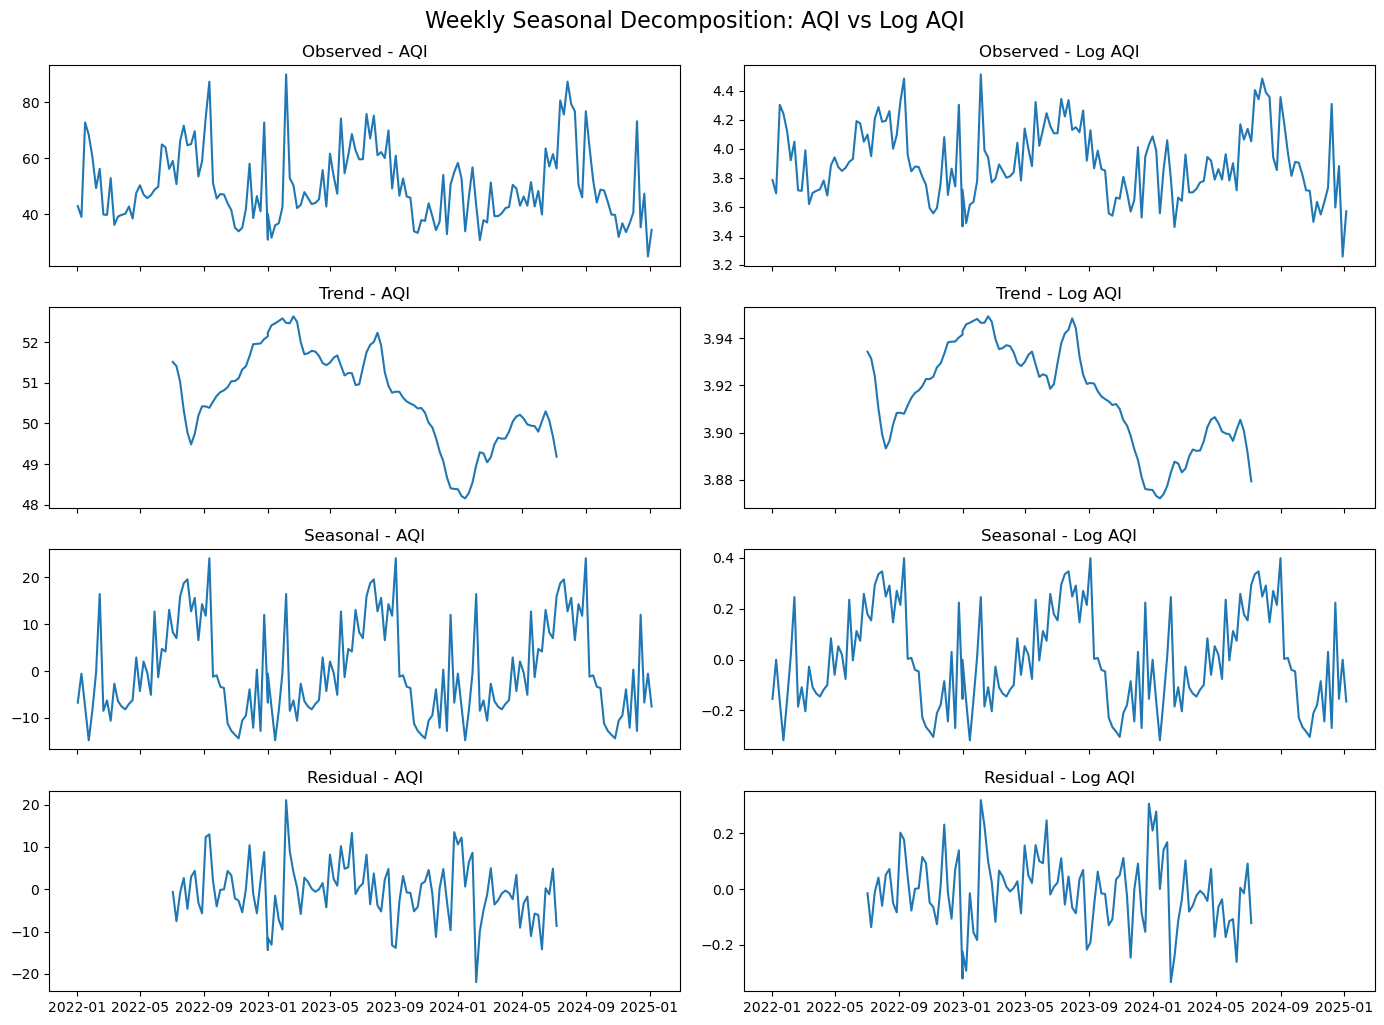

In [76]:
# Perform decomposition
result_aqi = seasonal_decompose(df_all_weekly['AQI'], model='additive', period=52)
result_log = seasonal_decompose(df_all_weekly['AQI_log'], model='additive', period=52)

# Create a figure with 4 rows and 2 columns
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)

# Titles for each row
components = ['Observed', 'Trend', 'Seasonal', 'Residual']

# Plot each component for both AQI and log AQI
for i, comp in enumerate(components):
    comp_name = 'resid' if comp == 'Residual' else comp.lower()
    axes[i, 0].plot(getattr(result_aqi, comp_name))
    axes[i, 0].set_title(f'{comp} - AQI')

    axes[i, 1].plot(getattr(result_log, comp_name))
    axes[i, 1].set_title(f'{comp} - Log AQI')

# Adjust layout
plt.tight_layout()
plt.suptitle('Weekly Seasonal Decomposition: AQI vs Log AQI', fontsize=16, y=1.02)
plt.show()


The seasonal decomposition shows there are several spikes in data here and there, but most importantly there is oscillating behavior in the visuals which means air quality does suffer from seasonality.

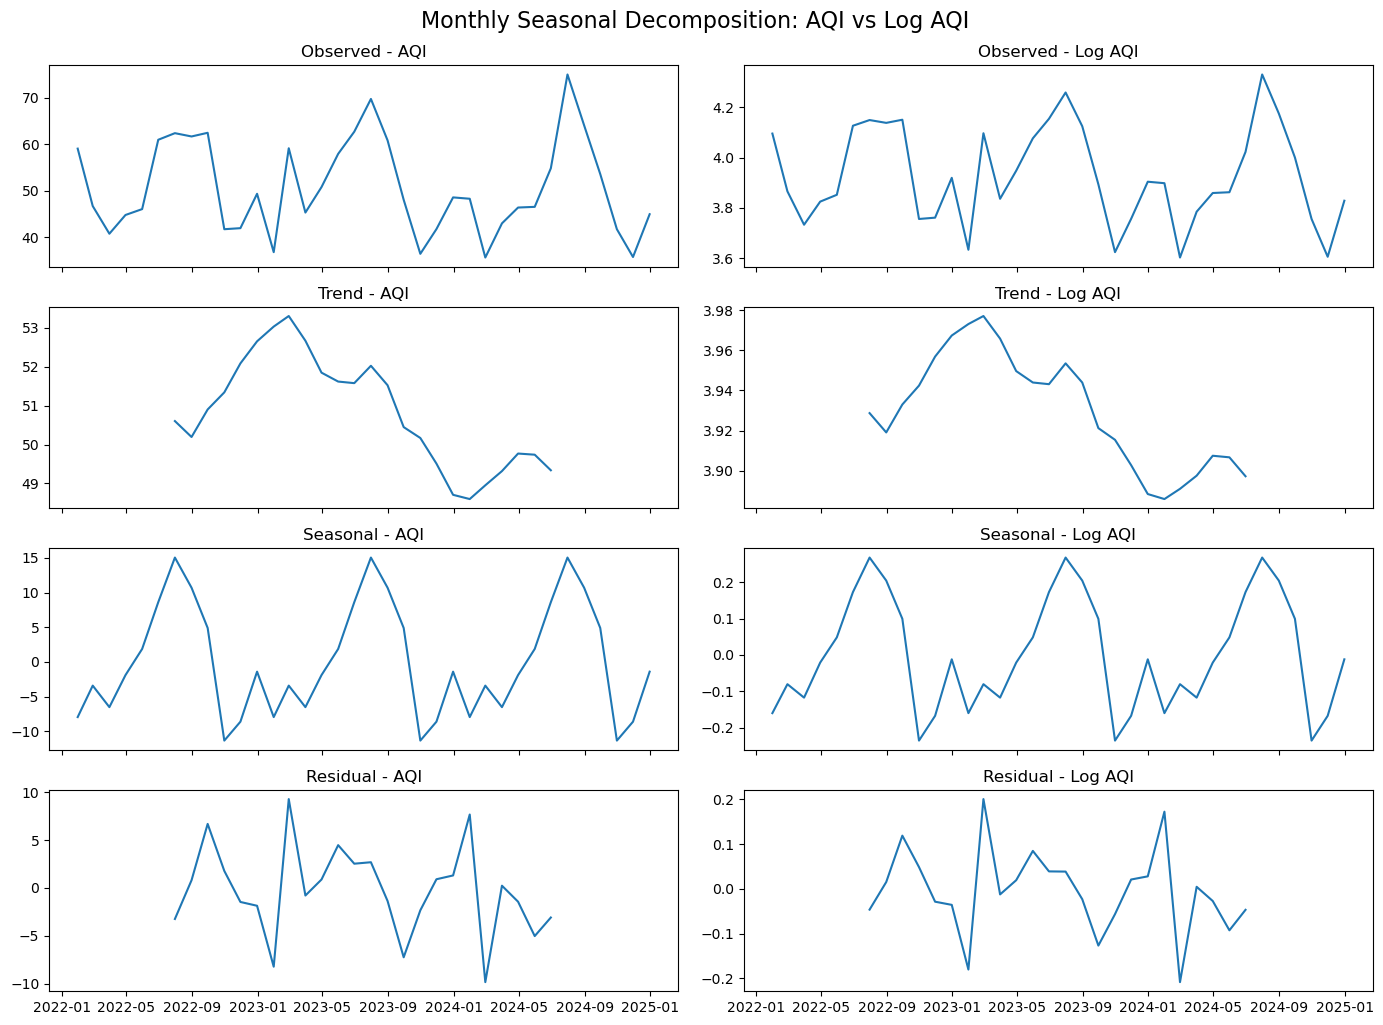

In [77]:
# Perform decomposition
result_aqi = seasonal_decompose(df_all_monthly['AQI'], model='additive', period=12)
result_log = seasonal_decompose(df_all_monthly['AQI_log'], model='additive', period=12)

# Create a figure with 4 rows and 2 columns
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)

# Titles for each row
components = ['Observed', 'Trend', 'Seasonal', 'Residual']

# Plot each component for both AQI and log AQI
for i, comp in enumerate(components):
    comp_name = 'resid' if comp == 'Residual' else comp.lower()
    axes[i, 0].plot(getattr(result_aqi, comp_name))
    axes[i, 0].set_title(f'{comp} - AQI')

    axes[i, 1].plot(getattr(result_log, comp_name))
    axes[i, 1].set_title(f'{comp} - Log AQI')

# Adjust layout
plt.tight_layout()
plt.suptitle('Monthly Seasonal Decomposition: AQI vs Log AQI', fontsize=16, y=1.02)
plt.show()


Since the trend and seasonality of this data was so obvious when looking at the values graphed, I wanted to also see what the monthly data looked like, and it is much more obvious that there is a major trend going on in this data.

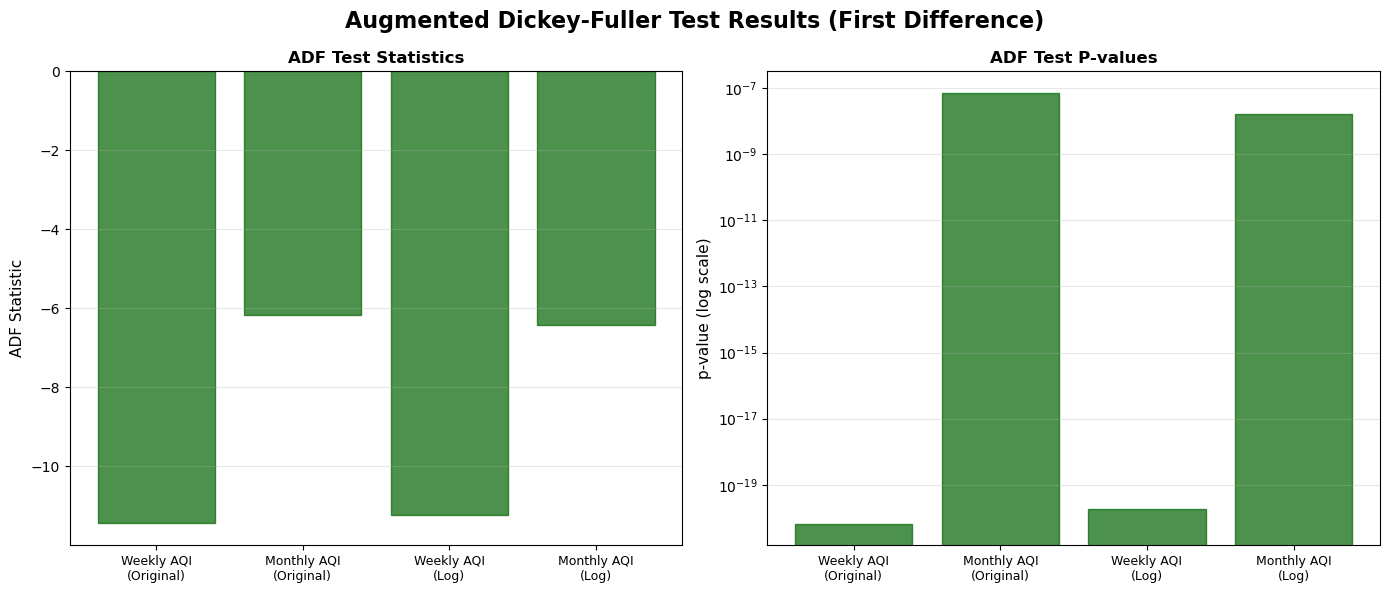

In [78]:
# --- Perform ADF tests on first differences and store results ---
adf_diff_results = []

# Weekly AQI first difference
aqi_diff_weekly = df_all_weekly['AQI'].diff().dropna()
adf_weekly_diff = adfuller(aqi_diff_weekly)
adf_diff_results.append({
    'Dataset': 'Weekly AQI',
    'Transformation': 'Original',
    'ADF Statistic': adf_weekly_diff[0],
    'p-value': adf_weekly_diff[1],
    'Critical Value (1%)': adf_weekly_diff[4]['1%'],
    'Critical Value (5%)': adf_weekly_diff[4]['5%']
})

# Monthly AQI first difference
aqi_diff_monthly = df_all_monthly['AQI'].diff().dropna()
adf_monthly_diff = adfuller(aqi_diff_monthly)
adf_diff_results.append({
    'Dataset': 'Monthly AQI',
    'Transformation': 'Original',
    'ADF Statistic': adf_monthly_diff[0],
    'p-value': adf_monthly_diff[1],
    'Critical Value (1%)': adf_monthly_diff[4]['1%'],
    'Critical Value (5%)': adf_monthly_diff[4]['5%']
})

# Weekly AQI Log first difference
aqi_diff_weekly_log = df_all_weekly['AQI_log'].diff().dropna()
adf_weekly_log_diff = adfuller(aqi_diff_weekly_log)
adf_diff_results.append({
    'Dataset': 'Weekly AQI',
    'Transformation': 'Log',
    'ADF Statistic': adf_weekly_log_diff[0],
    'p-value': adf_weekly_log_diff[1],
    'Critical Value (1%)': adf_weekly_log_diff[4]['1%'],
    'Critical Value (5%)': adf_weekly_log_diff[4]['5%']
})

# Monthly AQI Log first difference
aqi_diff_monthly_log = df_all_monthly['AQI_log'].diff().dropna()
adf_monthly_log_diff = adfuller(aqi_diff_monthly_log)
adf_diff_results.append({
    'Dataset': 'Monthly AQI',
    'Transformation': 'Log',
    'ADF Statistic': adf_monthly_log_diff[0],
    'p-value': adf_monthly_log_diff[1],
    'Critical Value (1%)': adf_monthly_log_diff[4]['1%'],
    'Critical Value (5%)': adf_monthly_log_diff[4]['5%']
})

# Create DataFrame
adf_diff_df = pd.DataFrame(adf_diff_results)

# --- Create visualization ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Augmented Dickey-Fuller Test Results (First Difference)', fontsize=16, fontweight='bold')

# Plot 1: ADF Statistics
ax1 = axes[0]
x_pos = np.arange(len(adf_diff_df))
bars = ax1.bar(x_pos, adf_diff_df['ADF Statistic'], color='steelblue', alpha=0.7, edgecolor='black')

# Color bars based on stationarity (if ADF stat < critical value at 5%, it's stationary)
for i, (bar, row) in enumerate(zip(bars, adf_diff_df.iterrows())):
    if row[1]['ADF Statistic'] < row[1]['Critical Value (5%)']:
        bar.set_color('darkgreen')
    else:
        bar.set_color('tomato')

# Add critical value lines
# ax1.axhline(y=adf_diff_df['Critical Value (5%)'].mean(), color='orange', 
#             linestyle='--', linewidth=2, label='Critical Value (5%)', alpha=0.7)
# ax1.axhline(y=adf_diff_df['Critical Value (1%)'].mean(), color='red', 
#             linestyle='--', linewidth=2, label='Critical Value (1%)', alpha=0.7)

ax1.set_xticks(x_pos)
ax1.set_xticklabels([f"{row['Dataset']}\n({row['Transformation']})" 
                      for _, row in adf_diff_df.iterrows()], fontsize=9)
ax1.set_ylabel('ADF Statistic', fontsize=11)
ax1.set_title('ADF Test Statistics', fontsize=12, fontweight='bold')
# ax1.legend(loc='lower right')
ax1.grid(axis='y', alpha=0.3)

# Add value labels
# for i, val in enumerate(adf_diff_df['ADF Statistic']):
#     ax1.text(i, val - 0.5, f'{val:.3f}', ha='center', va='top', fontsize=9)

# Plot 2: P-values (LOG SCALE)
ax2 = axes[1]

# Replace zeros with a very small number to avoid log(0) issues
pvals_plot = adf_diff_df['p-value'].replace(0, 1e-30)

bars2 = ax2.bar(x_pos, pvals_plot, color='steelblue', alpha=0.7, edgecolor='black')

# Color bars based on significance (p < 0.05 = stationary)
for bar, pval in zip(bars2, adf_diff_df['p-value']):
    if pval < 0.01:
        bar.set_color('darkgreen')
    elif pval < 0.05:
        bar.set_color('forestgreen')
    else:
        bar.set_color('tomato')

# Use log scale for y-axis
ax2.set_yscale('log')

# Add significance threshold lines
# ax2.axhline(y=0.05, color='orange', linestyle='--', linewidth=2, 
#             label='α = 0.05', alpha=0.7)
# ax2.axhline(y=0.01, color='red', linestyle='--', linewidth=2, 
#             label='α = 0.01', alpha=0.7)

ax2.set_xticks(x_pos)
ax2.set_xticklabels([f"{row['Dataset']}\n({row['Transformation']})" 
                      for _, row in adf_diff_df.iterrows()], fontsize=9)
ax2.set_ylabel('p-value (log scale)', fontsize=11)
ax2.set_title('ADF Test P-values', fontsize=12, fontweight='bold')
# ax2.legend(loc='upper right')
ax2.grid(axis='y', alpha=0.3, which='both')

# Add value labels
# for i, val in enumerate(adf_diff_df['p-value']):
#     label = f'{val:.2e}'
#     # Position text above the bar
#     y_pos = pvals_plot.iloc[i] * 2
#     ax2.text(i, y_pos, label, ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

We knew that there was seasonality in the data so by taking the season first difference we have adf stats that are more negative, and p-values that are even smaller, showing that the data has significant evidence that it is stationary.

Comparing the ADF p-value for the weekly aqi/logged-aqi values and the monthly aqi/logged-aqi values show that the p-value is very small meaning were making the data more stationarity.

##### Autocorrelation:

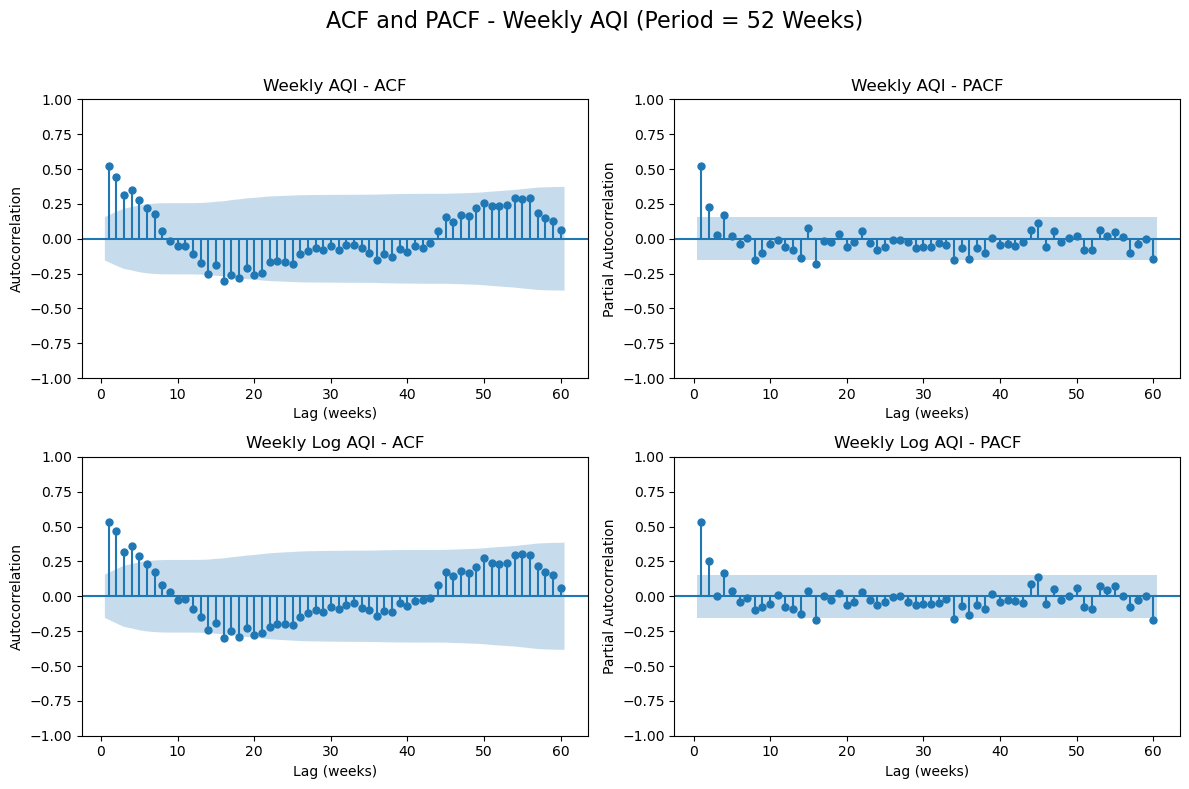

In [79]:
# --- Weekly data ---
weekly_series = {
    'Weekly AQI': df_all_weekly['AQI'].dropna(),
    'Weekly Log AQI': df_all_weekly['AQI_log'].dropna()
}

# --- Plot ACF and PACF for weekly data ---
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('ACF and PACF - Weekly AQI (Period = 52 Weeks)', fontsize=16)

for i, (label, series) in enumerate(weekly_series.items()):
    plot_acf(series, lags=60, ax=axes[i, 0], zero=False)
    axes[i, 0].set_title(f'{label} - ACF')
    axes[i, 0].set_xlabel('Lag (weeks)')
    axes[i, 0].set_ylabel('Autocorrelation')

    plot_pacf(series, lags=60, ax=axes[i, 1], zero=False, method='ywm')
    axes[i, 1].set_title(f'{label} - PACF')
    axes[i, 1].set_xlabel('Lag (weeks)')
    axes[i, 1].set_ylabel('Partial Autocorrelation')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


The lags show that at about lag 8, we start to see a reverse of direction in correlation. This must mean that as it looks back further in the year, since the weather changes this also changes AQI.

The PACF graph starts high, and after 1 lag has a steep drop off and then tails off with no clear pattern. This can be interpreted as after 1 lag, there isn't a direct strong influence on the weekly AQI values.

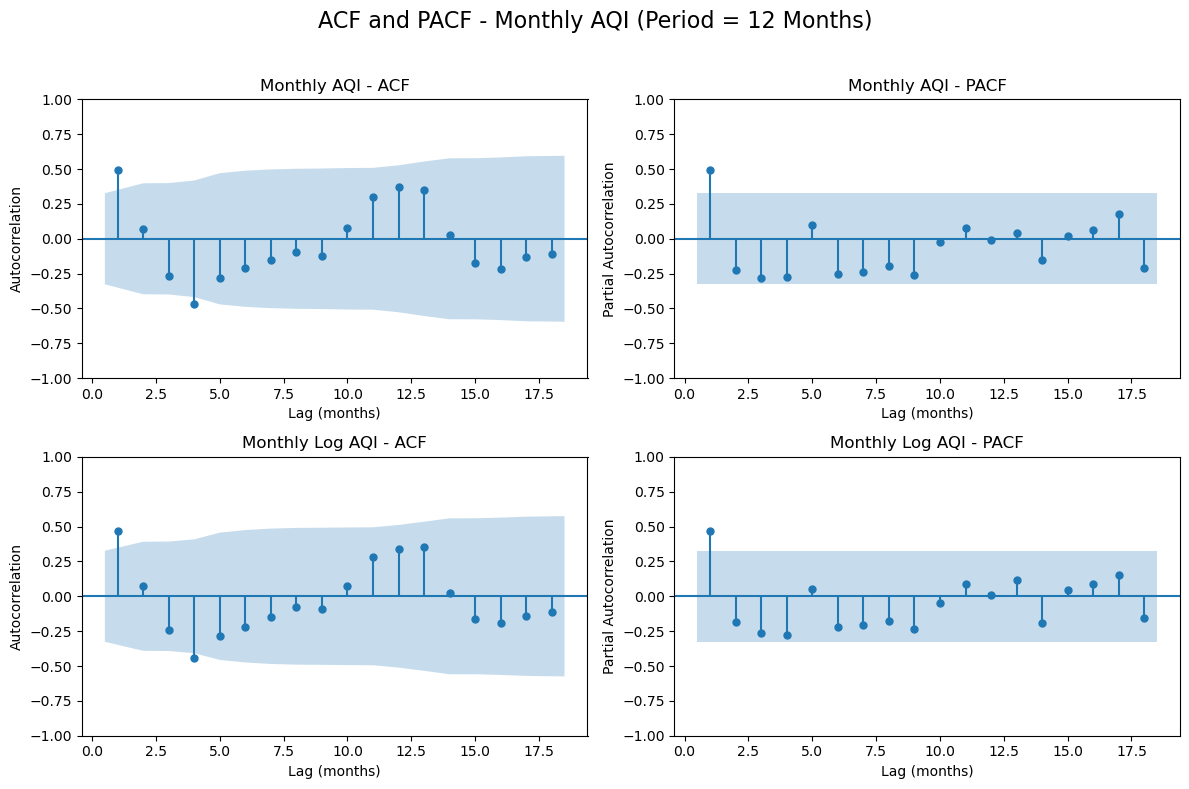

In [80]:
# --- Monthly data ---
monthly_series = {
    'Monthly AQI': df_all_monthly['AQI'].dropna(),
    'Monthly Log AQI': df_all_monthly['AQI_log'].dropna()
}

# --- Plot ACF and PACF for monthly data ---
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('ACF and PACF - Monthly AQI (Period = 12 Months)', fontsize=16)

for i, (label, series) in enumerate(monthly_series.items()):
    plot_acf(series, lags=18, ax=axes[i, 0], zero=False)
    axes[i, 0].set_title(f'{label} - ACF')
    axes[i, 0].set_xlabel('Lag (months)')
    axes[i, 0].set_ylabel('Autocorrelation')

    plot_pacf(series, lags=18, ax=axes[i, 1], zero=False, method='ywm')
    axes[i, 1].set_title(f'{label} - PACF')
    axes[i, 1].set_xlabel('Lag (months)')
    axes[i, 1].set_ylabel('Partial Autocorrelation')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


The monthly ACF graphs show a similar pattern to the weekly ACF graphs. There is usually a seasonal pattern that can be explained by the changing of the seasons showing that there is a correlation effect on AQI from the seasonal changes.

The monthly PACF graph also shows similar results to the weekly PACF plot results because of the immediate steep drop off on lag 1, and then there is no clear pattern. This confirms the verdict above that there is no strong and direct influence from earlier months once the 1st month is accounted for.

##### Correlation Coefficients:

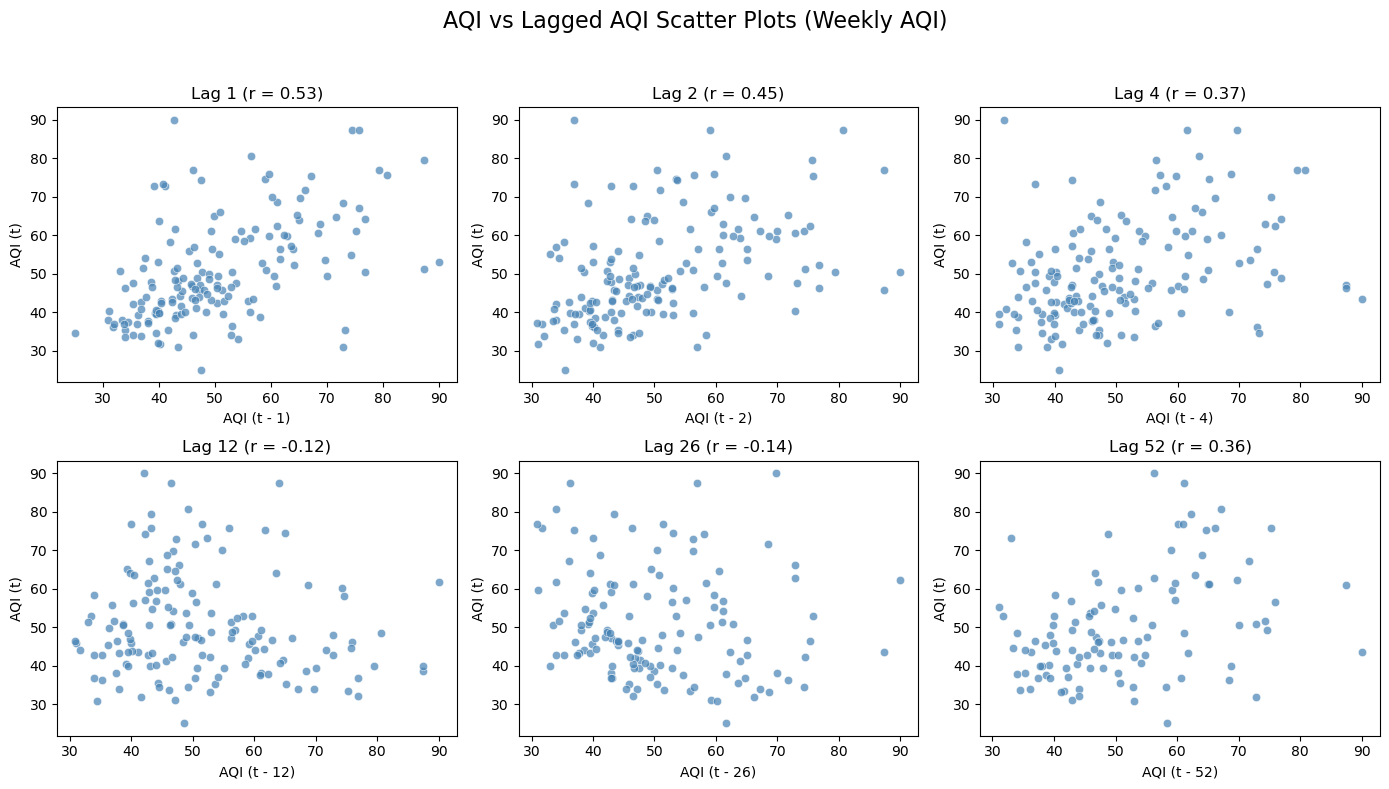

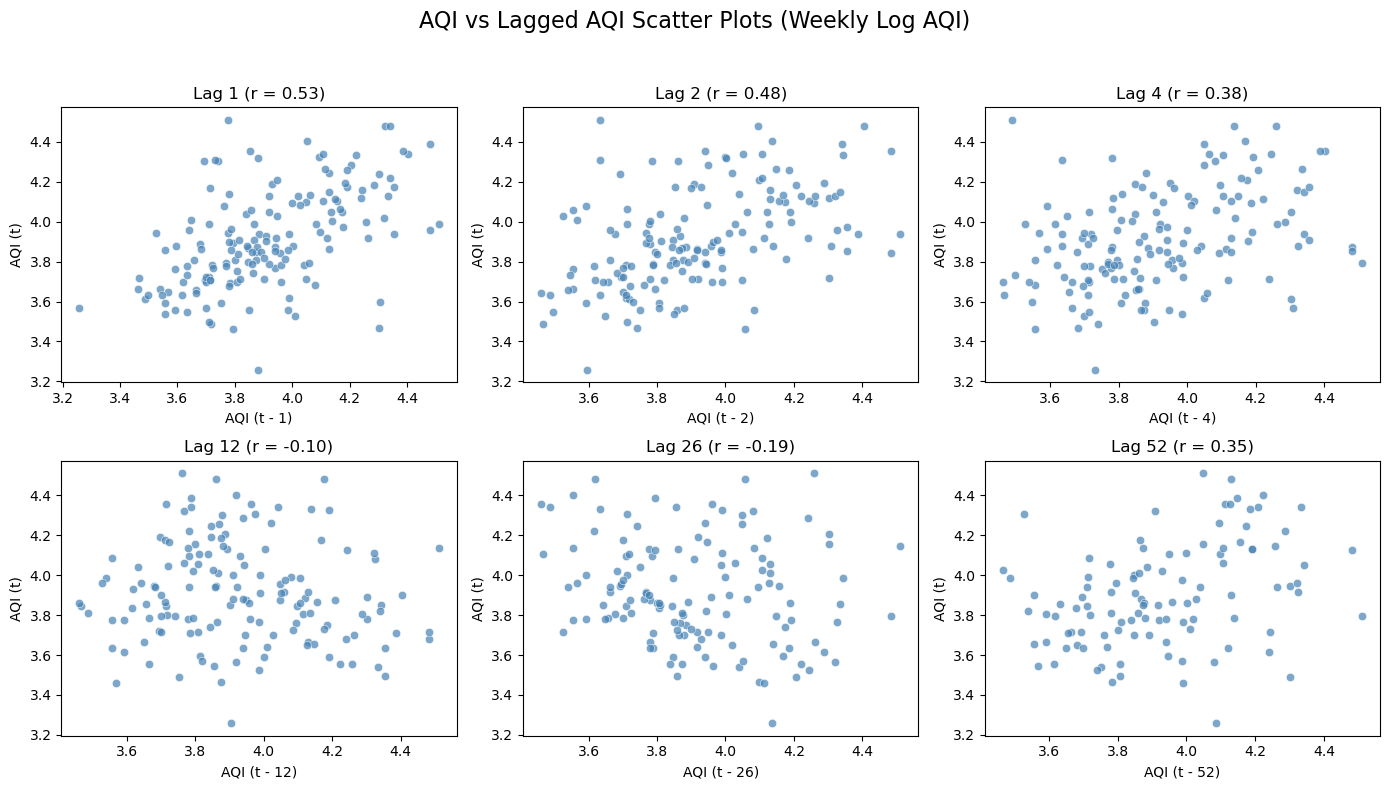

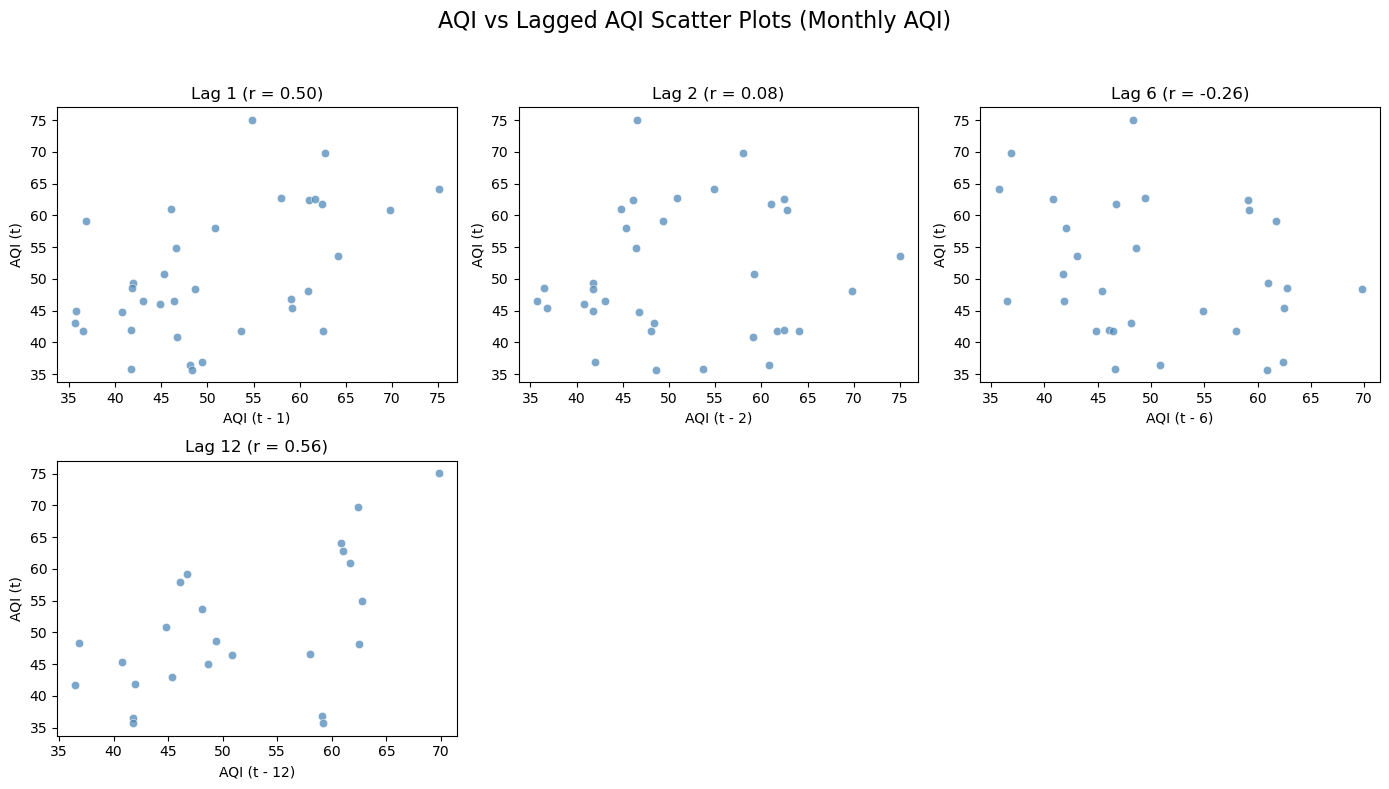

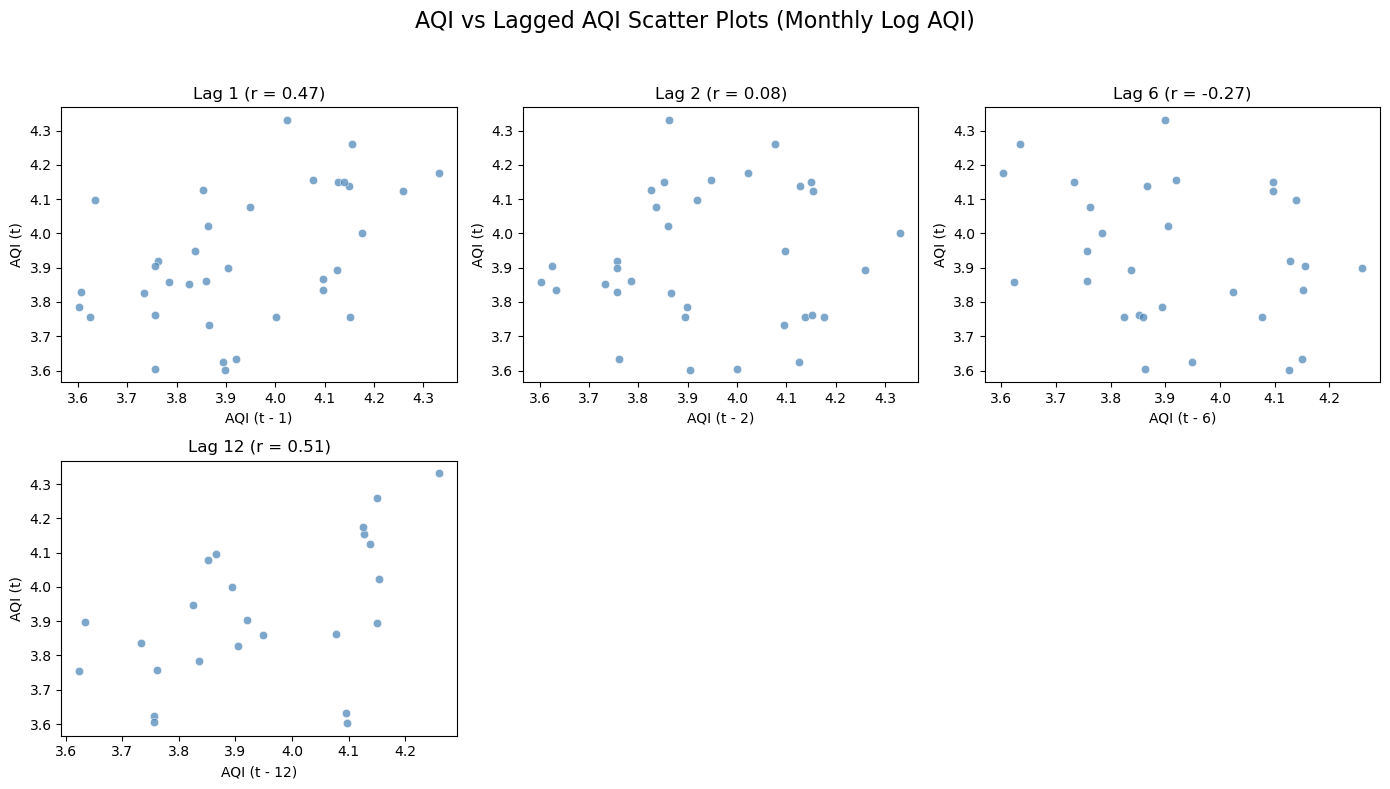

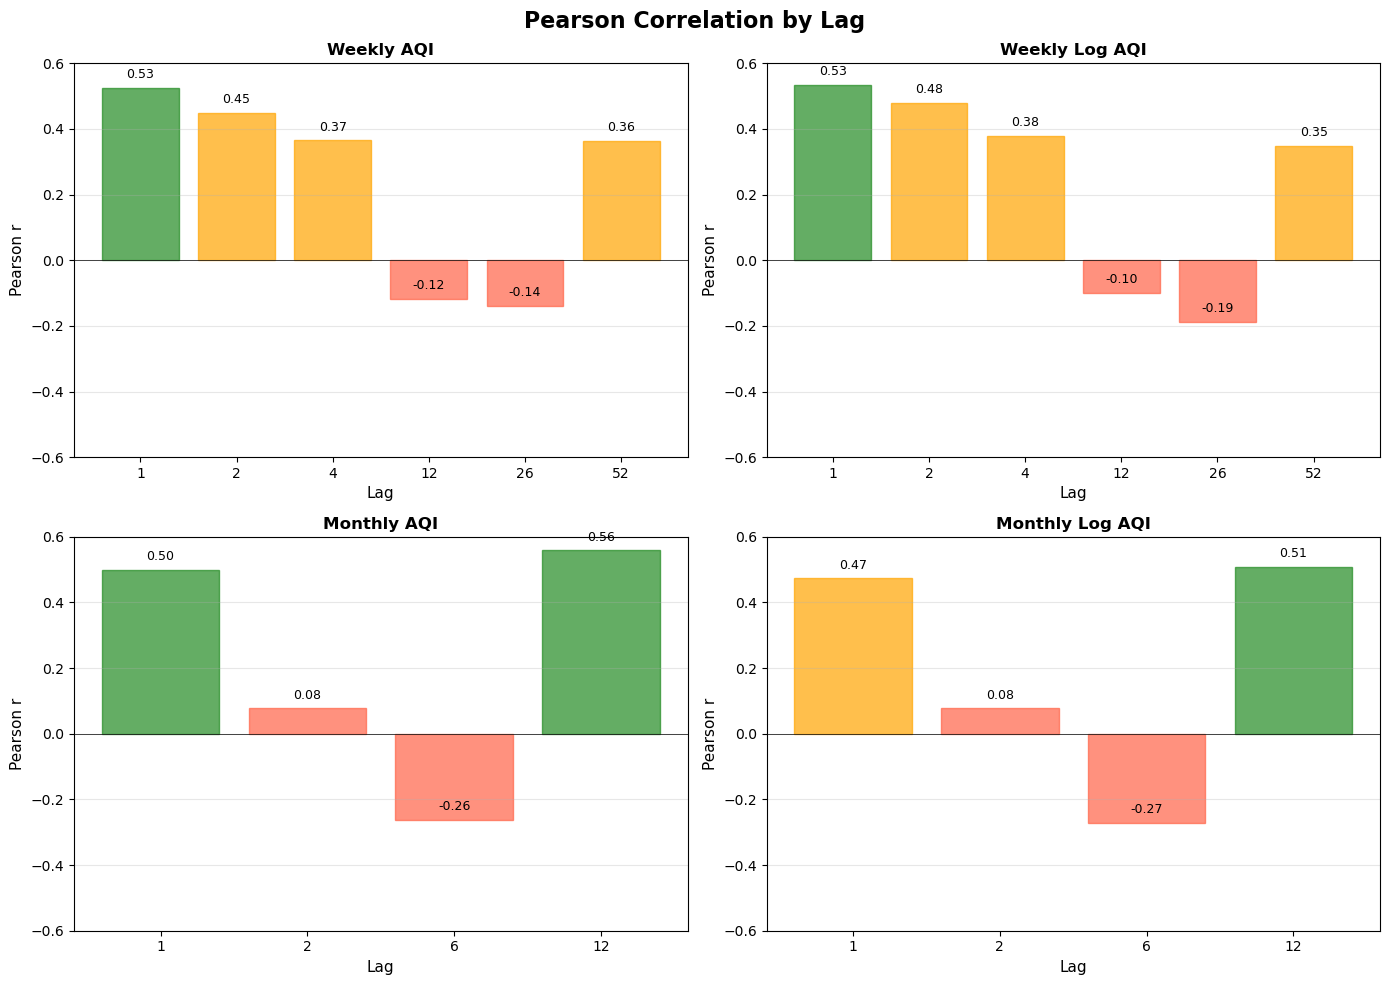

In [81]:
# --- Configuration ---
lags_to_check_weekly = [1, 2, 4, 12, 26, 52]   # 1–2 week short lags, 12/26 mid-season, 52 annual
lags_to_check_monthly = [1, 2, 6, 12]          # 1–2 month short lags, 6/12 mid/annual

# --- Store datasets and lag settings ---
datasets = {
    'Weekly AQI': (df_all_weekly['AQI'].dropna(), lags_to_check_weekly),
    'Weekly Log AQI': (df_all_weekly['AQI_log'].dropna(), lags_to_check_weekly),
    'Monthly AQI': (df_all_monthly['AQI'].dropna(), lags_to_check_monthly),
    'Monthly Log AQI': (df_all_monthly['AQI_log'].dropna(), lags_to_check_monthly)
}

# --- Dictionary to store all correlations ---
all_correlations = {}

# --- Loop over datasets ---
for name, (series, lags) in datasets.items():

    # Create figure for scatter plots
    n_lags = len(lags)
    ncols = 3
    nrows = (n_lags + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4 * nrows))
    fig.suptitle(f'AQI vs Lagged AQI Scatter Plots ({name})', fontsize=16)
    
    correlations = []
    
    for i, lag in enumerate(lags):
        # Compute lagged version
        df_temp = pd.DataFrame({
            'AQI': series,
            f'AQI_lag{lag}': series.shift(lag)
        }).dropna()
        
        # Pearson correlation for this lag
        corr = df_temp['AQI'].corr(df_temp[f'AQI_lag{lag}'])
        correlations.append((lag, corr))
        
        # Plot scatter
        ax = axes.flat[i]
        sns.scatterplot(
            data=df_temp, x=f'AQI_lag{lag}', y='AQI', ax=ax,
            color='steelblue', alpha=0.7
        )
        ax.set_title(f'Lag {lag} (r = {corr:.2f})')
        ax.set_xlabel(f'AQI (t - {lag})')
        ax.set_ylabel('AQI (t)')
    
    # Hide empty subplots if any
    for j in range(i + 1, len(axes.flat)):
        axes.flat[j].set_visible(False)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    # Store correlations for this dataset
    all_correlations[name] = correlations

# --- Create 2x2 summary figure for Pearson r scores ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Pearson Correlation by Lag', fontsize=16, fontweight='bold')

dataset_names = list(all_correlations.keys())
for idx, name in enumerate(dataset_names):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Extract lags and correlations
    lags = [item[0] for item in all_correlations[name]]
    corrs = [item[1] for item in all_correlations[name]]
    
    # Create bar plot
    bars = ax.bar(range(len(lags)), corrs, color='steelblue', alpha=0.7, edgecolor='black')
    
    # Color bars by correlation strength
    for bar, corr in zip(bars, corrs):
        if corr >= 0.7:
            bar.set_color('darkgreen')
        elif corr >= 0.5:
            bar.set_color('forestgreen')
        elif corr >= 0.3:
            bar.set_color('orange')
        else:
            bar.set_color('tomato')
    
    ax.set_xticks(range(len(lags)))
    ax.set_xticklabels(lags)
    ax.set_xlabel('Lag', fontsize=11)
    ax.set_ylabel('Pearson r', fontsize=11)
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([-.6, .6])
    
    # Add value labels on bars
    for i, (lag, corr) in enumerate(zip(lags, corrs)):
        ax.text(i, corr + 0.02, f'{corr:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

The weekly correlation shows seasonality due to what I'd assume literal seasons, like fall, winter, summer, and spring. It makes sense that on a lag of 1, there is a positive correlation because it is still within the season. However, looking at lags 12, and 26, that is comparing data to a different season which causes a negative correlation reversing the correlation. I can say since I started this lag in January, 26 weeks ago January is in the summer, June or July, so it makes sense the lag would calculate a negative correlation.

Looking at the monthly data pretty much confirms this as well, since looking at lag 6 shows a negative correlation with the current value meaning winter is colder than summer. So, we can confirm that there are correlation and seasonality in this data, and we will now be able to select a model to forecast the AQI.

Comparing the pearson_r scores with the plotted ACF graph shows they both agree with each other reinforcing that correlation and seasonality is present in this data due to changing seasons.

##### Data Splitting:

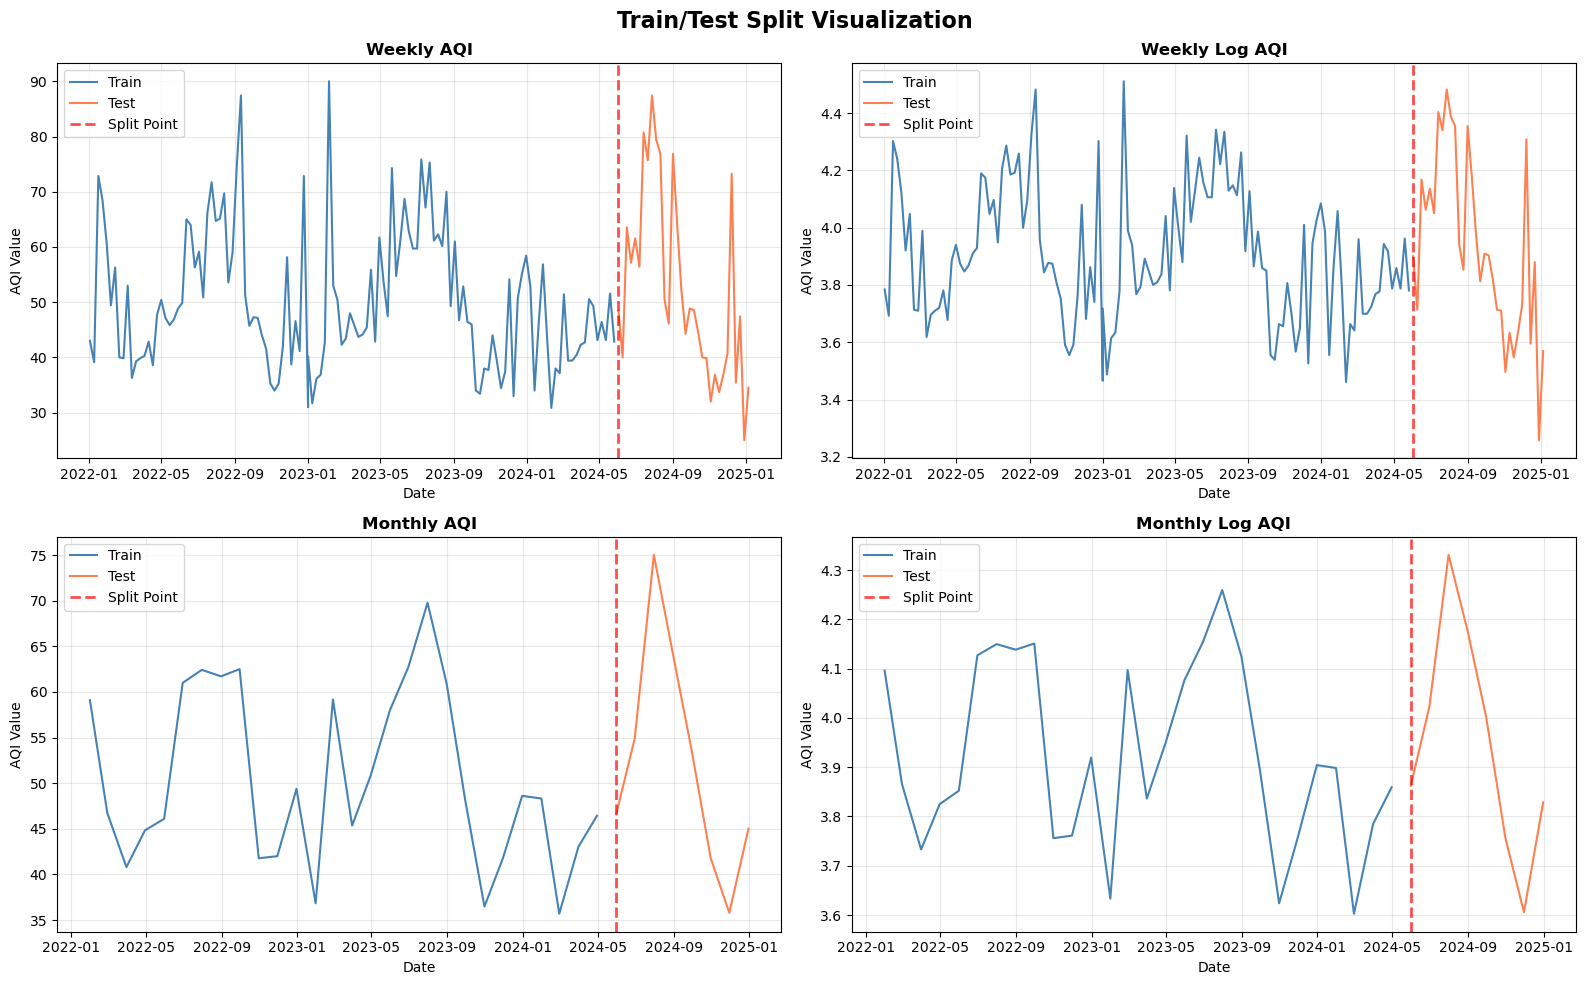

In [82]:
# --- Configuration ---
TRAIN_TEST_SPLIT = 0.8  # 80% train, 20% test

# Define datasets
datasets_config = {
    'Weekly AQI': {
        'data': df_all_weekly['AQI'].dropna(),
        'logged': False,
        'frequency': 'W',
        'seasonal_period': 52
    },
    'Weekly Log AQI': {
        'data': df_all_weekly['AQI_log'].dropna(),
        'logged': True,
        'frequency': 'W',
        'seasonal_period': 52
    },
    'Monthly AQI': {
        'data': df_all_monthly['AQI'].dropna(),
        'logged': False,
        'frequency': 'M',
        'seasonal_period': 12
    },
    'Monthly Log AQI': {
        'data': df_all_monthly['AQI_log'].dropna(),
        'logged': True,
        'frequency': 'M',
        'seasonal_period': 12
    }
}

# --- Step 1: Split Data ---
# print("="*80)
# print("STEP 1: DATA SPLITTING")
# print("="*80)

split_data = {}
for name, config in datasets_config.items():
    series = config['data']
    split_idx = int(len(series) * TRAIN_TEST_SPLIT)
    
    train = series.iloc[:split_idx]
    test = series.iloc[split_idx:]
    
    split_data[name] = {
        'train': train,
        'test': test,
        'config': config
    }
    
    # print(f"\n{name}:")
    # print(f"  Total observations: {len(series)}")
    # print(f"  Train size: {len(train)} ({len(train)/len(series)*100:.1f}%)")
    # print(f"  Test size: {len(test)} ({len(test)/len(series)*100:.1f}%)")
    # print(f"  Train period: {train.index[0]} to {train.index[-1]}")
    # print(f"  Test period: {test.index[0]} to {test.index[-1]}")

# --- Visualize Train/Test Split ---
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Train/Test Split Visualization', fontsize=16, fontweight='bold')

for idx, (name, data) in enumerate(split_data.items()):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    train = data['train']
    test = data['test']
    
    ax.plot(train.index, train.values, label='Train', color='steelblue', linewidth=1.5)
    ax.plot(test.index, test.values, label='Test', color='coral', linewidth=1.5)
    ax.axvline(x=test.index[0], color='red', linestyle='--', linewidth=2, alpha=0.7, label='Split Point')
    
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('AQI Value', fontsize=10)
    ax.legend(loc='best')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

##### Model Selection:

In [83]:
# Weekly:

# SARIMA(1,0,0)(1,1,0)[52] - This is also quite good.

# SARIMA(1,1,1)(1,1,1)[52] - might have been the best weekly predictions

# SARIMA(2,1,1)(1,1,1)[52] or SARIMA(1,1,2)(1,1,1)[52] - try adding another AR or MA term |  || Did alright
# This one might have been for forecasting btbh. This one, or the simpler (1,1,1)(1,1,1,[52])....

# SARIMA(1,1,1)(2,1,1)[52] or SARIMA(1,1,1)(1,1,2)[52] - explore richer seasonal structure CURRENT || this did alright, kind of bad tbh

# SARIMA(0,1,1)(0,1,1)[52] - simpler model (sometimes less is more) | equally as bad nearly

# Monthly:

# SARIMA(2,0,0)(1,0,0)[12] - add another non-seasonal AR lag | BAD

# SARIMA(1,0,1)(1,0,0)[12] - add MA component |  || The normal monthly was bad, but the Monthly LOG was good.
# Best for LOG

# SARIMA(1,0,0)(2,0,0)[12] or SARIMA(1,0,0)(1,0,1)[12] - richer seasonal terms | CURRENT || awful. infinite upwards bye bye.

# SARIMA(1,1,1)(1,1,1)[12] - Log did ight, but the non-log was crap.
# Best for non log.

I tested different p, d, q, P, D, and Q values for the SARIMAX model, and made decisions based on the ACF/PACF plots and how stationary my data was.
What I found was that taking the difference and seasonal difference impacted all the models except for the logged aqi positively. Also, setting p/P and q/Q to a value of 1 also showed better forecasting and results. These values set to 1 helped the model capture short-term autocorrelation which we saw a little bit of in the ACF plots, and the seasonal trends were apparent from graphed data so both p/P and q/Q helped the model perform well.

In [84]:
# --- Step 2: Manual Model Specification ---
# print("\n" + "="*80)
# print("STEP 2: MANUAL MODEL SPECIFICATION")
# print("="*80)

# better selected?
manual_models = {
    'Weekly AQI': {
        'order': (1, 1, 1),
        'seasonal_order': (1, 1, 1, 52)
    },
    'Weekly Log AQI': {
        'order': (1, 1, 1),
        'seasonal_order': (1, 1, 1, 52)
    },
    'Monthly AQI': {
        'order': (1, 1, 1),
        'seasonal_order': (1, 1, 1, 12)
    },
    'Monthly Log AQI': {
        'order': (1, 0, 1),
        'seasonal_order': (1, 0, 0, 12)
    }
}

# print("\nFitting SARIMA models...")
best_models = {}

for name, data in split_data.items():
    # print(f"\n{name}:")
    # print("-" * len(name))
    
    train = data['train']
    params = manual_models[name]
    
    # print(f"  Fitting SARIMA{params['order']} x {params['seasonal_order']}...")
    
    model = SARIMAX(
        train,
        order=params['order'],
        seasonal_order=params['seasonal_order'],
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results = model.fit(disp=False)
    
    best_models[name] = {
        'model': results,
        'order': params['order'],
        'seasonal_order': params['seasonal_order'],
        'aic': results.aic,
        'bic': results.bic
    }
    
    # print(f"  Model fitted successfully")
    # print(f"  AIC: {results.aic:.2f}")
    # print(f"  BIC: {results.bic:.2f}")

##### Model Parameters and Diagnostics:

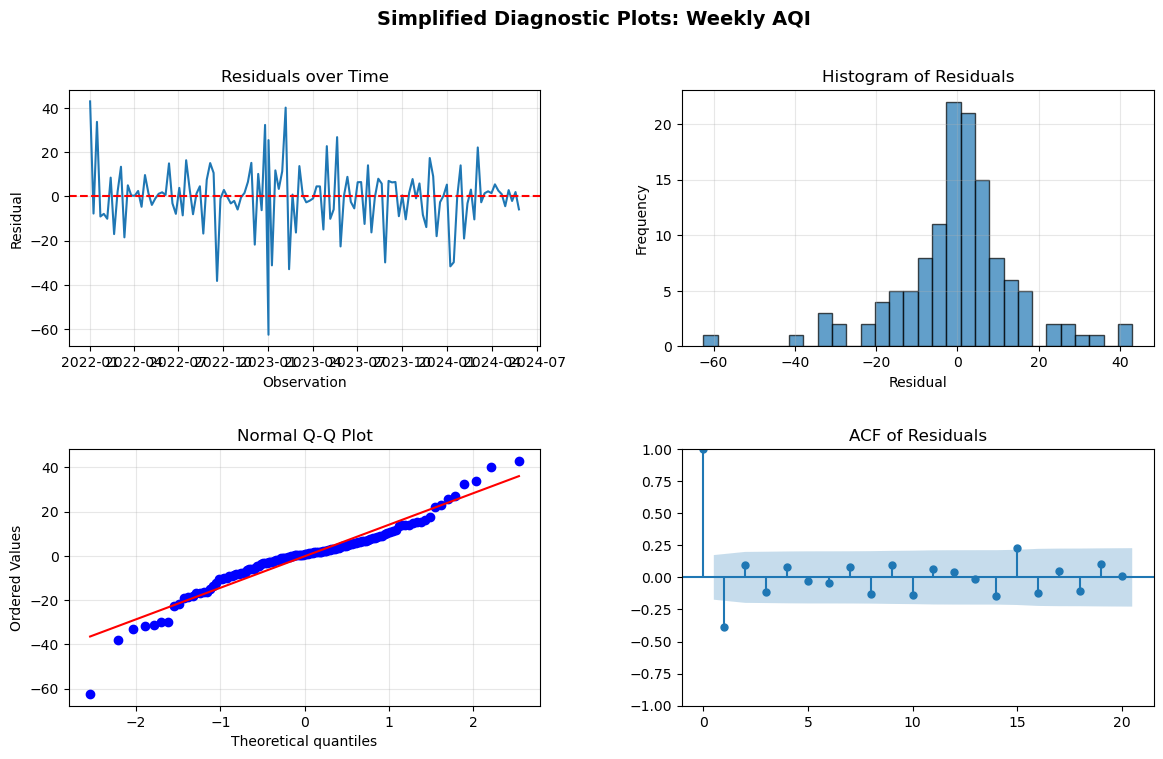

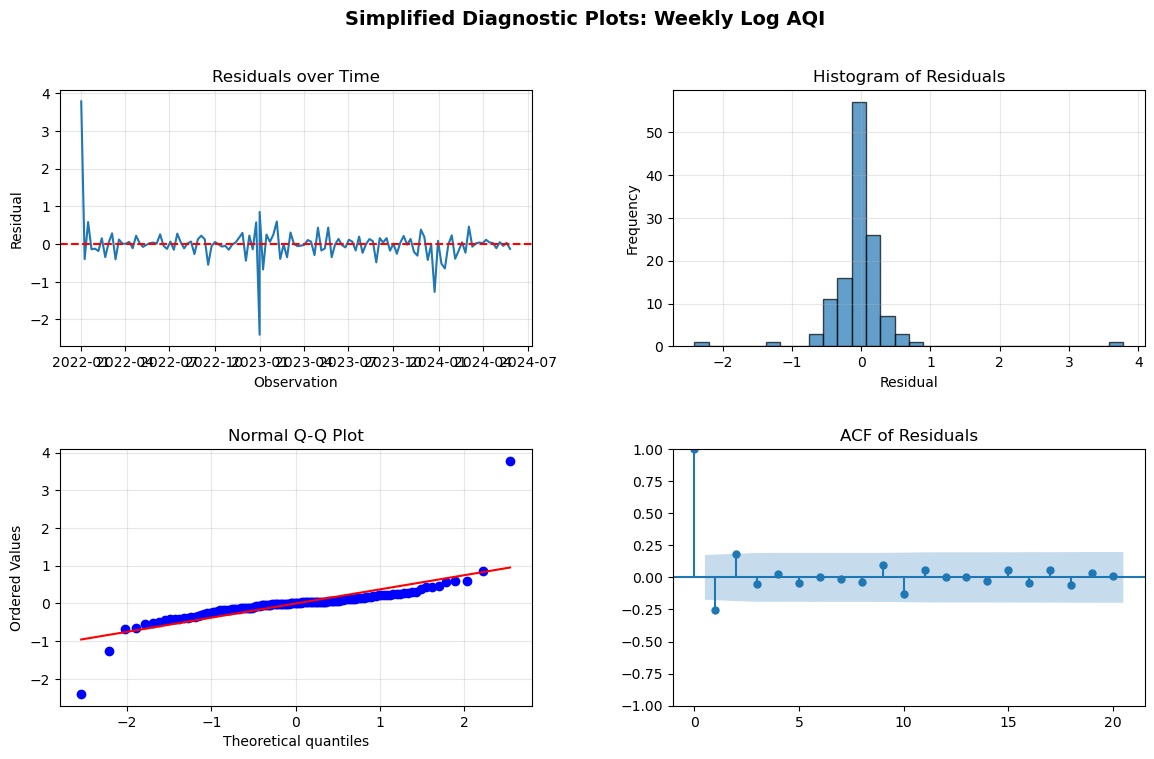

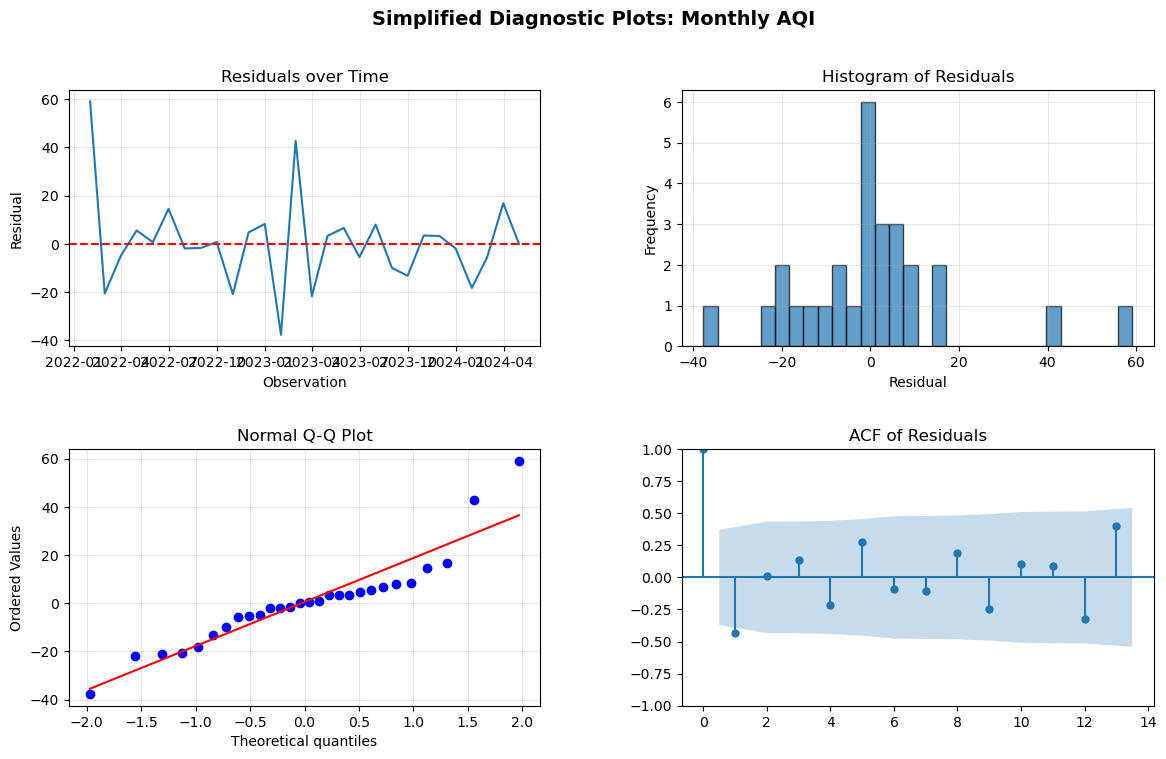

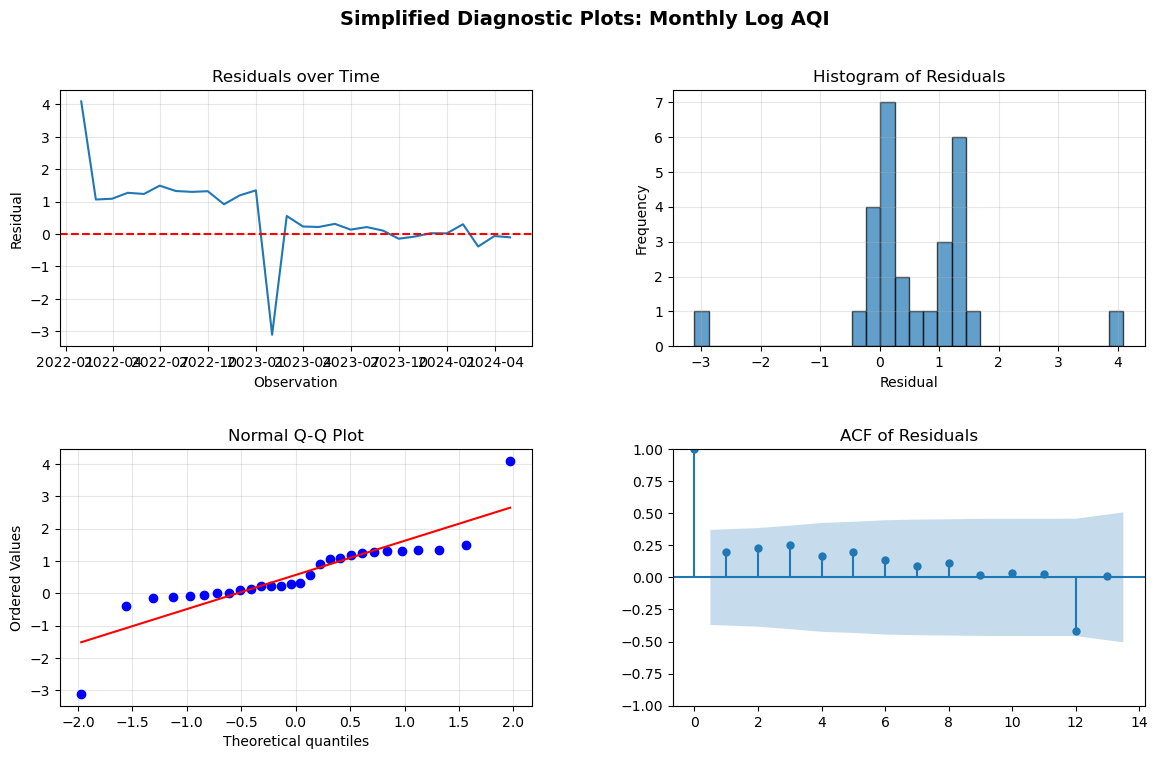

In [85]:
for name, model_info in best_models.items():
    residuals = model_info['model'].resid
        
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    fig.suptitle(f'Simplified Diagnostic Plots: {name}', fontsize=14, fontweight='bold')
    
    # Residual plot
    axes[0, 0].plot(residuals)
    axes[0, 0].axhline(y=0, color='red', linestyle='--')
    axes[0, 0].set_title('Residuals over Time')
    axes[0, 0].set_xlabel('Observation')
    axes[0, 0].set_ylabel('Residual')
    axes[0, 0].grid(alpha=0.3)
    
    # Histogram of residuals
    axes[0, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    axes[0, 1].set_title('Histogram of Residuals')
    axes[0, 1].set_xlabel('Residual')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(alpha=0.3)
    
    # Q-Q plot
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Normal Q-Q Plot')
    axes[1, 0].grid(alpha=0.3)
    
    # ACF of residuals (with fewer lags)
    max_lags = min(20, len(residuals) // 2 - 1)
    plot_acf(residuals, lags=max_lags, ax=axes[1, 1])
    axes[1, 1].set_title('ACF of Residuals')
    fig.subplots_adjust(hspace=0.4, wspace=0.3)

    # fig = model_info['model'].plot_diagnostics(figsize=(14, 8))
    # fig.suptitle(f'Diagnostic Plots: {name}', fontsize=14, fontweight='bold', y=1.00)
#     # Diagnostic plots with error handling
#     try:
#         fig = model_info['model'].plot_diagnostics(figsize=(14, 8))
#         fig.suptitle(f'Diagnostic Plots: {name}', fontsize=14, fontweight='bold', y=1.00)
#         # plt.tight_layout()
#         # plt.show()
#     except ValueError as e:
#         # print(f"\n  Warning: Could not generate diagnostic plots for {name}")
#         # print(f"  Reason: {str(e)}")
#         # print(f"  This typically occurs when there are insufficient observations for the seasonal period.")
#         # print(f"  The model is still valid and can be used for forecasting.\n")
        
#         # Alternative: Plot just the residuals manually
#         # print(f"  Generating alternative residual plot...")
#         residuals = model_info['model'].resid
        
#         fig, axes = plt.subplots(2, 2, figsize=(14, 8))
#         fig.suptitle(f'Simplified Diagnostic Plots: {name}', fontsize=14, fontweight='bold')
        
#         # Residual plot
#         axes[0, 0].plot(residuals)
#         axes[0, 0].axhline(y=0, color='red', linestyle='--')
#         axes[0, 0].set_title('Residuals over Time')
#         axes[0, 0].set_xlabel('Observation')
#         axes[0, 0].set_ylabel('Residual')
#         axes[0, 0].grid(alpha=0.3)
        
#         # Histogram of residuals
#         axes[0, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
#         axes[0, 1].set_title('Histogram of Residuals')
#         axes[0, 1].set_xlabel('Residual')
#         axes[0, 1].set_ylabel('Frequency')
#         axes[0, 1].grid(alpha=0.3)
        
#         # Q-Q plot

#         stats.probplot(residuals, dist="norm", plot=axes[1, 0])
#         axes[1, 0].set_title('Normal Q-Q Plot')
#         axes[1, 0].grid(alpha=0.3)
        
#         # ACF of residuals (with fewer lags)
#         max_lags = min(20, len(residuals) // 2 - 1)
#         plot_acf(residuals, lags=max_lags, ax=axes[1, 1])
#         axes[1, 1].set_title('ACF of Residuals')
        
#         # plt.tight_layout()
#         # plt.show()

##### Forecasting:

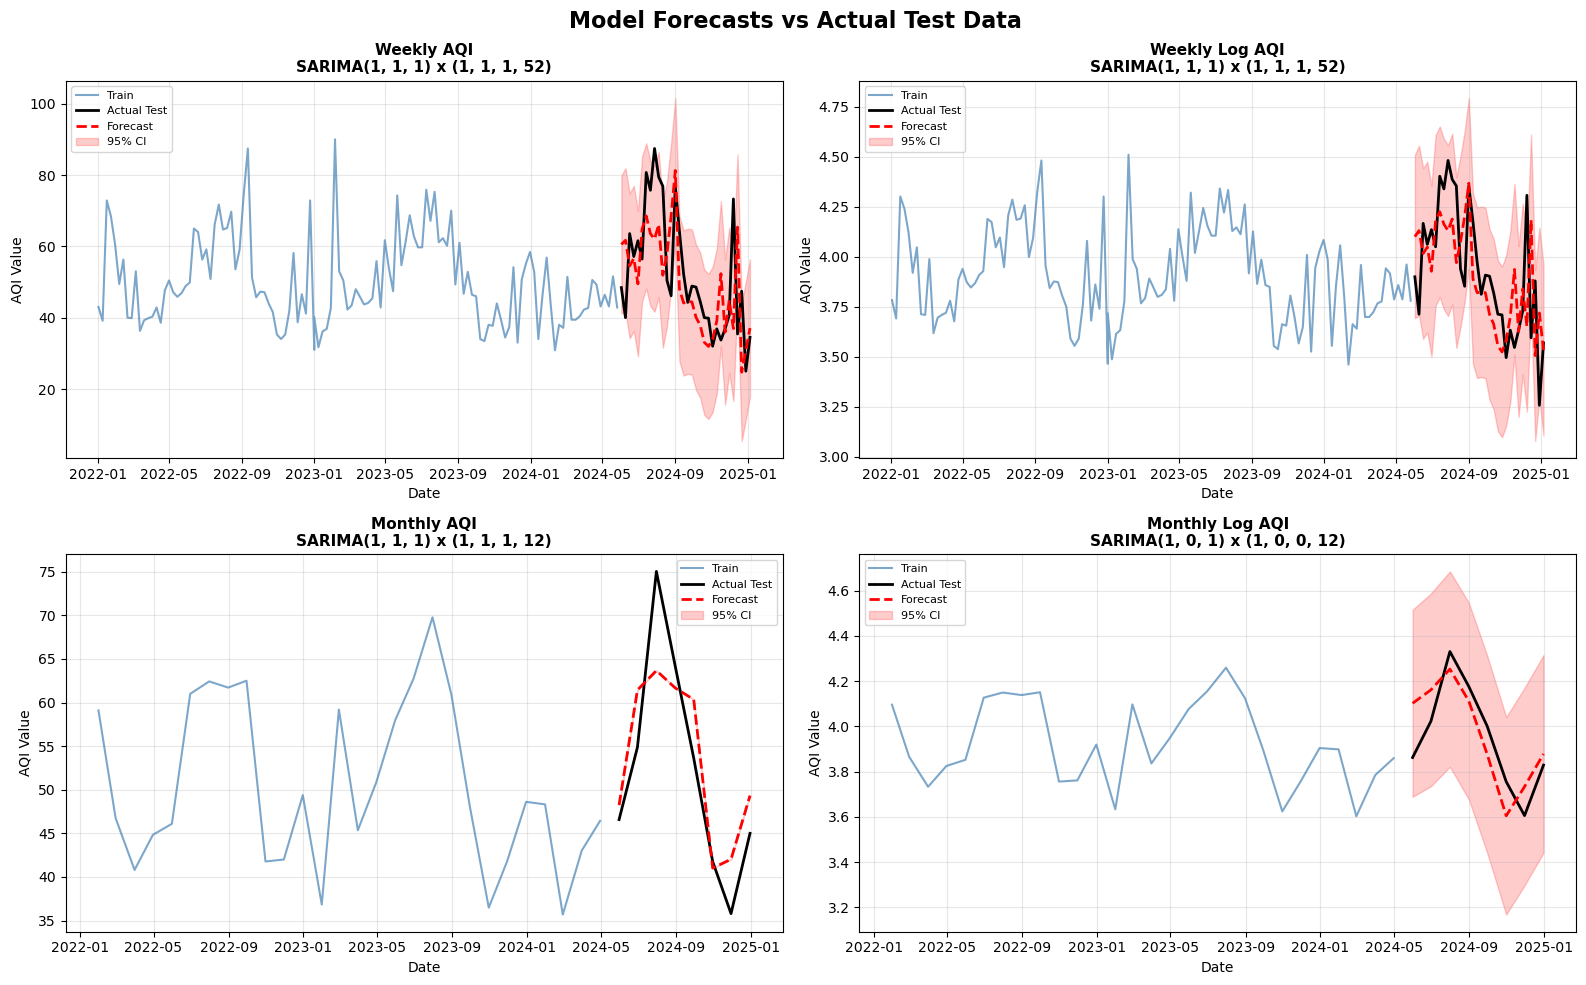

In [86]:

# --- Step 4: Forecasting ---
# print("\n" + "="*80)
# print("STEP 4: FORECASTING")
# print("="*80)

forecasts = {}

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Model Forecasts vs Actual Test Data', fontsize=16, fontweight='bold')

for idx, (name, data) in enumerate(split_data.items()):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    train = data['train']
    test = data['test']
    model = best_models[name]['model']
    
    # print(f"\nGenerating forecast for {name}...")
    
    # Forecast
    forecast_result = model.get_forecast(steps=len(test))
    forecast_mean = forecast_result.predicted_mean
    forecast_ci = forecast_result.conf_int()
    
    # Store forecast
    forecasts[name] = {
        'forecast': forecast_mean,
        'conf_int': forecast_ci,
        'actual': test
    }
    
    # Plot
    ax.plot(train.index, train.values, label='Train', color='steelblue', linewidth=1.5, alpha=0.7)
    ax.plot(test.index, test.values, label='Actual Test', color='black', linewidth=2)
    ax.plot(test.index, forecast_mean.values, label='Forecast', color='red', linewidth=2, linestyle='--')
    ax.fill_between(test.index, 
                     forecast_ci.iloc[:, 0], 
                     forecast_ci.iloc[:, 1], 
                     color='red', alpha=0.2, label='95% CI')
    
    ax.set_title(f"{name}\nSARIMA{best_models[name]['order']} x {best_models[name]['seasonal_order']}", 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('AQI Value', fontsize=10)
    ax.legend(loc='best', fontsize=8)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


##### Model Performance:

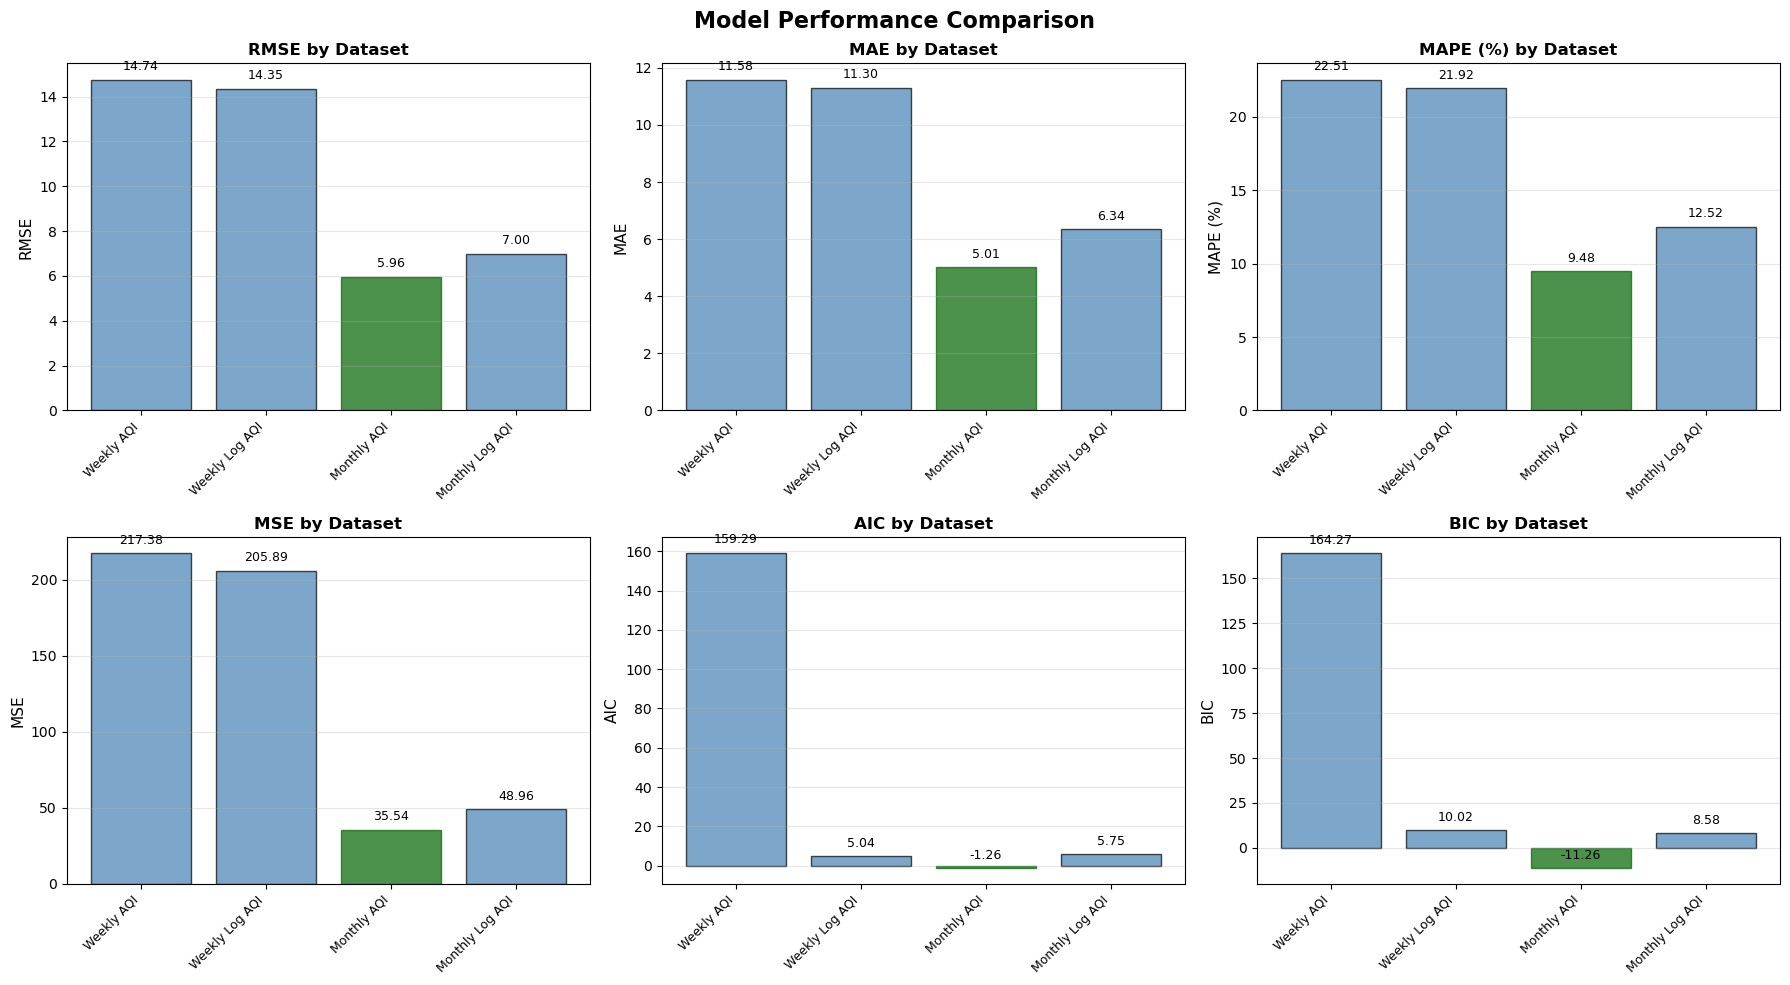

In [87]:

# --- Step 5: Model Performance Metrics ---
# print("\n" + "="*80)
# print("STEP 5: MODEL PERFORMANCE METRICS")
# print("="*80)

performance_results = []

for name, forecast_data in forecasts.items():
    actual = forecast_data['actual'].values
    predicted = forecast_data['forecast'].values
    
    # For logged data, transform back to original scale for metrics
    if split_data[name]['config']['logged']:
        actual_original = np.exp(actual)
        predicted_original = np.exp(predicted)
    else:
        actual_original = actual
        predicted_original = predicted
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(actual_original, predicted_original))
    mae = mean_absolute_error(actual_original, predicted_original)
    mape = mean_absolute_percentage_error(actual_original, predicted_original) * 100
    mse = mean_squared_error(actual_original, predicted_original)
    
    performance_results.append({
        'Dataset': name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (%)': mape,
        'MSE': mse,
        'AIC': best_models[name]['aic'],
        'BIC': best_models[name]['bic']
    })
    
    # print(f"\n{name}:")
    # print(f"  RMSE: {rmse:.4f}")
    # print(f"  MAE: {mae:.4f}")
    # print(f"  MAPE: {mape:.2f}%")
    # print(f"  MSE: {mse:.4f}")
    # print(f"  AIC: {best_models[name]['aic']:.2f}")
    # print(f"  BIC: {best_models[name]['bic']:.2f}")

# Create performance comparison DataFrame
performance_df = pd.DataFrame(performance_results)

# --- Performance Visualization ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['RMSE', 'MAE', 'MAPE (%)', 'MSE', 'AIC', 'BIC']
for idx, metric in enumerate(metrics):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    x_pos = np.arange(len(performance_df))
    values = performance_df[metric]
    
    bars = ax.bar(x_pos, values, color='steelblue', alpha=0.7, edgecolor='black')
    
    # Color the best (lowest) bar green
    best_idx = values.idxmin()
    bars[best_idx].set_color('darkgreen')
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(performance_df['Dataset'], rotation=45, ha='right', fontsize=9)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} by Dataset', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, val in enumerate(values):
        ax.text(i, val + (values.max() * 0.02), f'{val:.2f}', 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

##### Residual Analysis

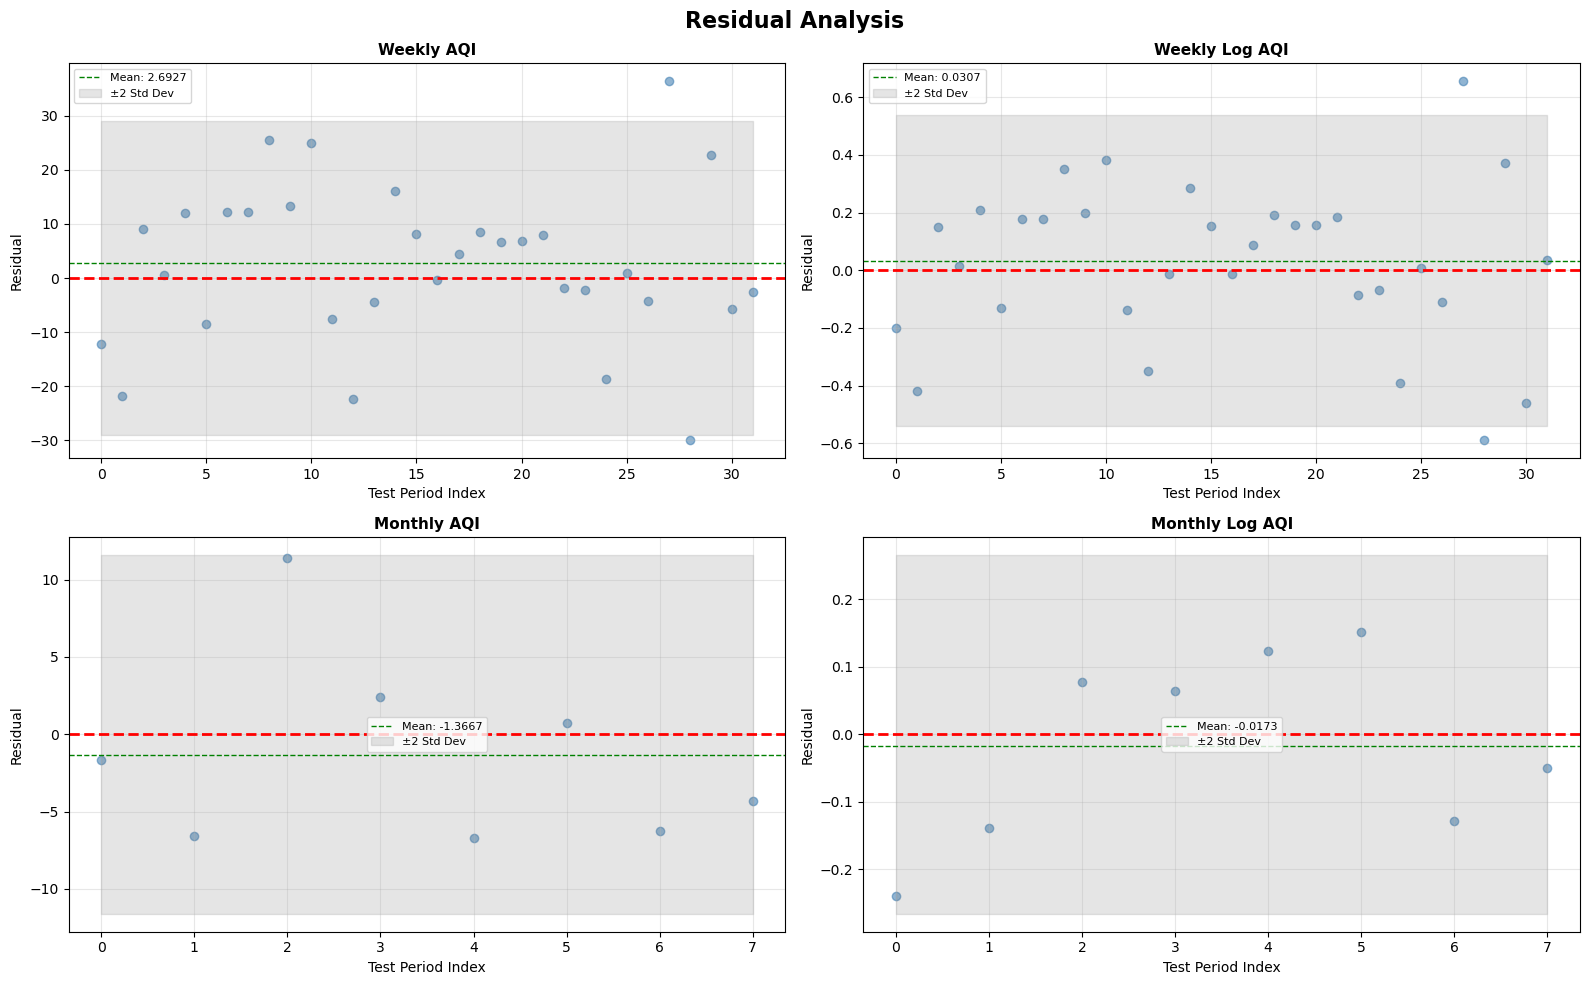

In [88]:
# --- Residual Analysis ---
# print("\n" + "="*80)
# print("RESIDUAL ANALYSIS")
# print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Residual Analysis', fontsize=16, fontweight='bold')

for idx, (name, forecast_data) in enumerate(forecasts.items()):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    actual = forecast_data['actual'].values
    predicted = forecast_data['forecast'].values
    residuals = actual - predicted
    
    # Plot residuals
    ax.scatter(range(len(residuals)), residuals, alpha=0.6, color='steelblue')
    ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
    ax.axhline(y=np.mean(residuals), color='green', linestyle='--', linewidth=1, label=f'Mean: {np.mean(residuals):.4f}')
    ax.fill_between(range(len(residuals)), 
                     -2*np.std(residuals), 
                     2*np.std(residuals), 
                     alpha=0.2, color='gray', label='±2 Std Dev')
    
    ax.set_title(f'{name}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Test Period Index', fontsize=10)
    ax.set_ylabel('Residual', fontsize=10)
    ax.legend(loc='best', fontsize=8)
    ax.grid(alpha=0.3)
    
    # print(f"\n{name}:")
    # print(f"  Mean Residual: {np.mean(residuals):.6f}")
    # print(f"  Std Dev Residual: {np.std(residuals):.6f}")

plt.tight_layout()
plt.show()

##### Final Model Equation:

In [89]:

# # --- Summary Table ---
# print("\n" + "="*80)
# print("PERFORMANCE SUMMARY TABLE")
# print("="*80)
# print(performance_df.to_string(index=False))

# # --- Final Model Equations ---
# print("\n" + "="*80)
# print("FINAL MODEL EQUATIONS")
# print("="*80)

for name, model_info in best_models.items():
    order = model_info['order']
    seasonal_order = model_info['seasonal_order']
    if name == 'Monthly AQI':
        print(f"\n{name}:")
        print(f"  SARIMA{order} x {seasonal_order}")
        print(f"  Notation: SARIMA(p={order[0]}, d={order[1]}, q={order[2]}) x "
              f"(P={seasonal_order[0]}, D={seasonal_order[1]}, Q={seasonal_order[2]}, s={seasonal_order[3]})")
        print(f"  Model: (1 - φ₁B)(1 - Φ₁B^{seasonal_order[3]})(1 - B)(1 - B^{seasonal_order[3]})Yₜ = (1 + θ₁B)(1 + Θ₁B^{seasonal_order[3]})εₜ")

# # --- Best Model Recommendation ---
# print("\n" + "="*80)
# print("BEST MODEL RECOMMENDATION")
# print("="*80)

# Find best model based on multiple criteria
best_rmse_idx = performance_df['RMSE'].idxmin()
best_mae_idx = performance_df['MAE'].idxmin()
best_mape_idx = performance_df['MAPE (%)'].idxmin()
best_aic_idx = performance_df['AIC'].idxmin()

print("\nBest results by different criteria:")
print(f"  Lowest RMSE: {performance_df.loc[best_rmse_idx, 'Dataset']} (RMSE: {performance_df.loc[best_rmse_idx, 'RMSE']:.4f})")
print(f"  Lowest MAE: {performance_df.loc[best_mae_idx, 'Dataset']} (MAE: {performance_df.loc[best_mae_idx, 'MAE']:.4f})")
print(f"  Lowest MAPE: {performance_df.loc[best_mape_idx, 'Dataset']} (MAPE: {performance_df.loc[best_mape_idx, 'MAPE (%)']:.2f}%)")
print(f"  Lowest AIC: {performance_df.loc[best_aic_idx, 'Dataset']} (AIC: {performance_df.loc[best_aic_idx, 'AIC']:.2f})")

# print("\n" + "="*80)
# print("ANALYSIS COMPLETE")
# print("="*80)


Monthly AQI:
  SARIMA(1, 1, 1) x (1, 1, 1, 12)
  Notation: SARIMA(p=1, d=1, q=1) x (P=1, D=1, Q=1, s=12)
  Model: (1 - φ₁B)(1 - Φ₁B^12)(1 - B)(1 - B^12)Yₜ = (1 + θ₁B)(1 + Θ₁B^12)εₜ

Best results by different criteria:
  Lowest RMSE: Monthly AQI (RMSE: 5.9618)
  Lowest MAE: Monthly AQI (MAE: 5.0084)
  Lowest MAPE: Monthly AQI (MAPE: 9.48%)
  Lowest AIC: Monthly AQI (AIC: -1.26)


##### Conclusion:

This was an interesting study for many reasons. Firstly, since the time series data did have seasonality, it was a good exercise to discover what order difference, and seasonal differences to apply to the data. Since the dataset was populated quite well, and there weren't any missing dates, there was no need for dropping N/A values or imputing so that was nice to not have to handle that. Focusing on the ACF/PACF, stationarity, and variance let me think more about the seasonality of the data, and which p/d/q values to choose for the arima model. 

In the end the best performing model was the base monthly AQI model that was aggregated monthly by average. However, the forecasted results given by this best performing model still couldn’t capture the spike, similarly to most of the other models. I wonder what could have been done to the data/modeling that would capture the spike for the last couple weeks, or months in the dataset.
